In [1]:
%pip install humanfriendly

/home/lukas/school/tree-statistics/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ['MEMORY_LIMIT'] = '16GB'

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  
from datetime import timedelta

In [2]:
ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')

In [3]:
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [4]:
BASEPATH = 'resources/results/'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        join_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(join_times_path):
            print(alg, 'is not computed for', dataset, f'{join_times_path} skipping')
            continue
        df = pd.read_csv(join_times_path, names=["time"])
        
        candidate_eval_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(candidate_eval_times_path):
            print(alg, 'is not computed for', dataset, f'{candidate_eval_times_path} skipping')
            continue
        lb_df = pd.read_csv(candidate_eval_times_path, names=["query_filter_time_us"])
        
        with open(join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')) as f:
            selectivity_line = f.readline()
            rest = f.read()
            
            if not selectivity_line.startswith('Mean selectivi'):
                rest = selectivity_line + rest

        # sel = selectivity_line.split(':')[1]
        # sel = float(sel.rstrip('%\n'))
        # print(sel)
        # seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, lb_df]
    return algorithm_times

In [6]:
# tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]
tested_values= [('bolzano', 6), ('sentiment', 10), ('ptb', 15), ('treefam', 60), ('python', 15), ('dblp', 6), ('swissprot', 5)]

In [8]:
dataframes = dict()
for ds, t in tested_values:
    try:
        dataframes[ds] = load_dataset(ds, t)
    except Exception:
        print('Failed getting results from ', ds)

Failed getting results from  bolzano
Failed getting results from  sentiment
Failed getting results from  ptb
Failed getting results from  treefam
Failed getting results from  python
Failed getting results from  dblp
structural is not computed for swissprot resources/results/swissprot/5/swissprot-Structural-times-us.txt skipping
structural-variant is not computed for swissprot resources/results/swissprot/5/swissprot-StructuralVariant-times-us.txt skipping
sed is not computed for swissprot resources/results/swissprot/5/swissprot-Sed-times-us.txt skipping
lblint is not computed for swissprot resources/results/swissprot/5/swissprot-Lblint-times-us.txt skipping
bib is not computed for swissprot resources/results/swissprot/5/swissprot-Bib-times-us.txt skipping
Failed getting results from  swissprot


In [8]:
selectivities = [ (ds, float(dataframes[ds]['sed'][1]['Mean Selectivity'][0].rstrip('%') ), t) for ds, t in tested_values ]
selectivity_df = pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])
selectivity_df

KeyError: 'bolzano'

In [9]:
datasets = [
    'bolzano',
    'ptb',
    'sentiment',
    'treefam',
    'rna',
    'dblp',
    'python',
    'swissprot',
]

In [7]:
def load_stats(dataset: str):
    ds_path = join('./resources/statistics', dataset.lower())
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(8, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(8, 'Min node degree', [degrees['degree'].min()])
    df.insert(8, 'Max node degree', [degrees['degree'].max()])
    df.insert(8, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(8, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(8, 'Tree/Label ratio', df['tree_count'] / df['distinct_labels'])
    df.insert(8, 'Tree size/Label ratio', (df['avg_tree'] / df['distinct_labels']) * 100)
    df.insert(8, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

times_df = pd.DataFrame()
for i, ds, in enumerate(datasets):
    row = int(i >= 4)
    col = i % 4
    try:
        loaded, dep, deg = load_stats(ds)
    except Exception as e:
        print('Failed to load statistics for', ds, str(e))
        continue
    times_df = pd.concat([times_df, loaded])

pd.set_option('display.precision', 3)

times_df.reset_index()
times_df = times_df.rename(columns={
    'min_tree': 'Min tree size',
    'max_tree': 'Max tree size',
    'avg_tree': 'Average tree size',
    'tree_count': 'Trees',
    'avg_unique_labels_per_tree': 'Avg. unique labels for a tree',
    'avg_tree_distinct_labels': 'Avg. distinct labels in tree',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})


# Collection statistics

- Average tree size => average node count in tree
- Trees => tree count in collection
- Avg. unique labels for a tree => Average collection wide unique labels (the average number of labels that are found only inside single tree)
- Avg. distinct labels in tree => Average distinct number of labels in each tree

In [8]:
display(times_df)

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels,Mean tree height (root to leaf distance),Tree size/Label ratio,Tree/Label ratio,Max tree height,Min tree height,Max node degree,Min node degree,Mean node degree
0,Dblp,9,1703,26.073,150000,5.814,23.909,992866,2.018,0.003,0.151,5,1,430,1,1.923
0,Ptb,3,711,71.595,3832,1.747,44.128,13094,6.874,0.547,0.293,29,2,33,1,1.972
0,Python,1,43270,948.242,49977,15.893,118.270,1479429,8.411,0.064,0.034,122,0,13974,0,1.998
0,Sentiment,2,102,36.360,9645,1.040,19.900,19468,7.270,0.187,0.495,29,1,3,1,1.945
0,Swissprot,63,15065,2665.613,5000,223.343,592.227,1276006,3.127,0.209,0.004,6,1,2844,1,1.995
0,Treefam,63,15065,2665.613,5000,223.343,592.227,1276006,16.709,0.209,0.004,54,2,8,1,1.999


In [9]:
def load_stats(datasets, stats_type: str):
    distinct_labels_stats = pd.DataFrame()
    for ds in datasets:
        try:
            ds_path = join('./resources/statistics', ds.lower())
            path = join(ds_path, stats_type + '.csv')
            df = pd.read_csv(path, header=None, names=[stats_type])
            df.insert(0, 'Dataset', [ds.capitalize()] * len(df.index), True)
            distinct_labels_stats = pd.concat([distinct_labels_stats, df])
        except Exception as e:
            print(f"Failed to load {stats_type} stats for {ds}: {e}")
    return distinct_labels_stats

unique_labels_stats = load_stats(datasets, 'tree_sizes')
# tree_sizes_stats = load_stats(datasets, 'tree_sizes')
unique_labels_stats.head()

,Dataset,tree_sizes
0,Dblp,9
1,Dblp,9
2,Dblp,13
3,Dblp,13
4,Dblp,13


In [15]:
t = unique_labels_stats[unique_labels_stats['Dataset'] == 'Ptb'].groupby('tree_sizes').size().reset_index(name='Counts')
t[t['tree_sizes'] > 60].head(20)

,tree_sizes,Counts
56,61,53
57,62,45
58,63,47
59,64,47
60,65,41
61,66,53
62,67,36
63,68,47
64,69,40
65,70,52


## Unique labels distribution

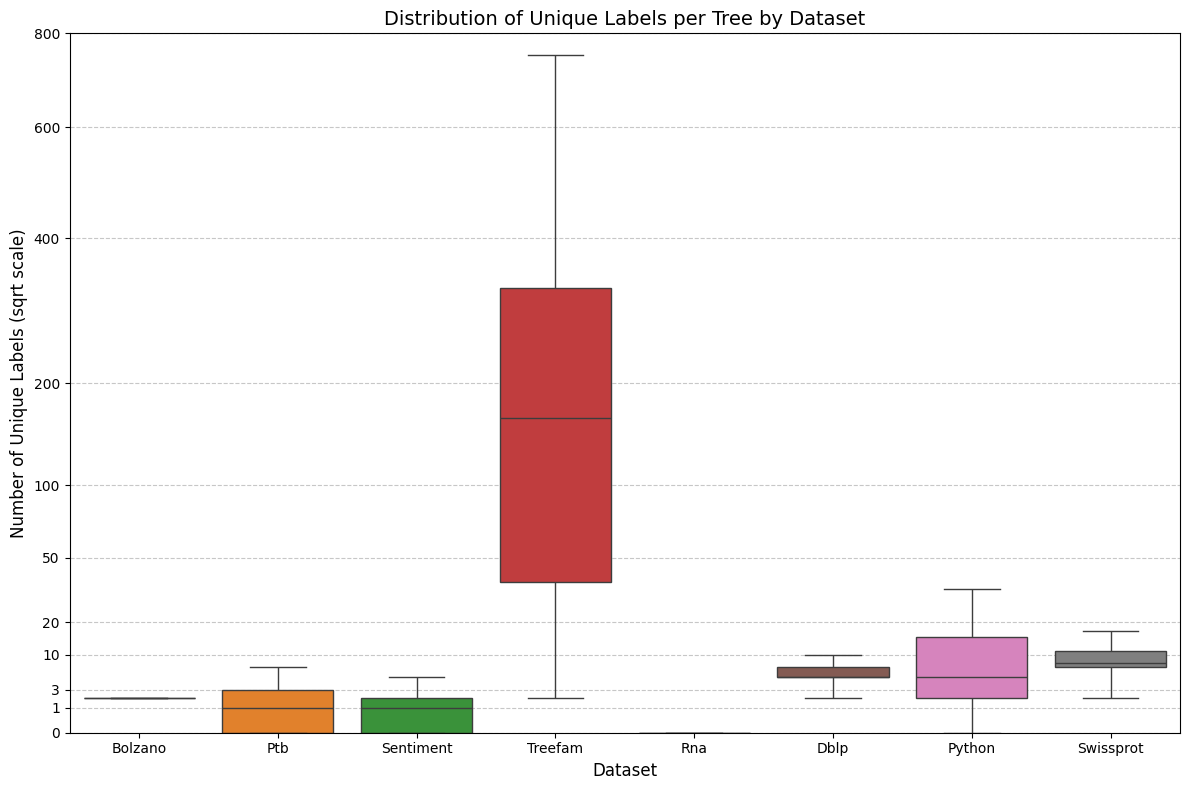

In [ ]:

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))
# Create boxplot with dataset as hue
ax = sns.boxplot(data=unique_labels_stats, hue="Dataset", x='Dataset', y='unique_labels', showfliers=False)
# Set the scale to sqrt using function-based scaling
ax.set_ylim(0, 800)
ax.set_yscale('function', functions=(np.sqrt, lambda x: x**2))
# Add customized yticks (starting from 5)
yticks = [0, 1, 3, 10, 20, 50, 100, 200, 400, 600, 800]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# Remove legend as it's redundant with x-axis labels
# ax.get_legend().remove()

# Customize the plot
ax.set_title('Distribution of Unique Labels per Tree by Dataset', fontsize=14)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Unique Labels (sqrt scale)', fontsize=12)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

## Distinct labels distribution

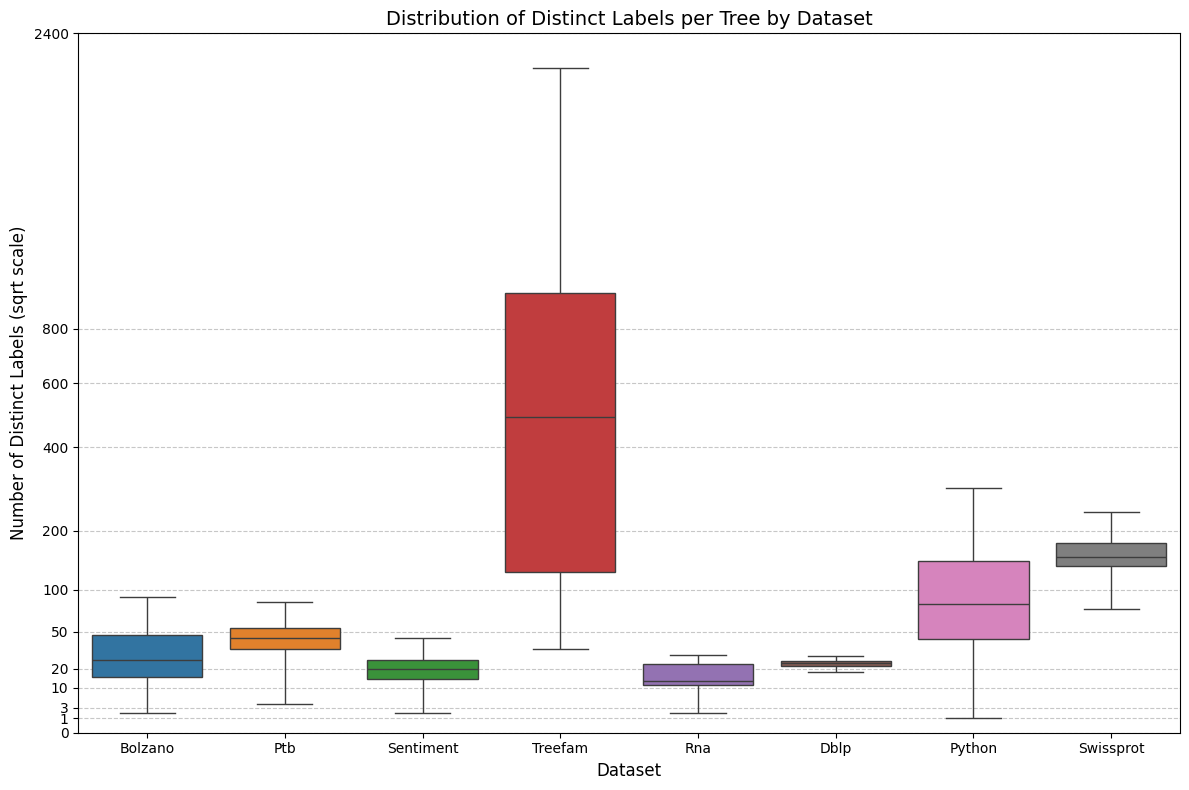

In [ ]:
distinct_labels_stats = load_stats(datasets, 'distinct_labels')
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))
# Create boxplot with dataset as hue
ax = sns.boxplot(data=distinct_labels_stats, hue="Dataset", x='Dataset', y='distinct_labels', showfliers=False)
# Set the scale to sqrt using function-based scaling
ax.set_ylim(0, 2400)
ax.set_yscale('function', functions=(np.sqrt, lambda x: x**2))
# Add customized yticks (starting from 5)
yticks = [0, 1, 3, 10, 20, 50, 100, 200, 400, 600, 800, 2400]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# Remove legend as it's redundant with x-axis labels
# ax.get_legend().remove()

# Customize the plot
ax.set_title('Distribution of Distinct Labels per Tree by Dataset', fontsize=14)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Distinct Labels (sqrt scale)', fontsize=12)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()


## Distribution of Tree Sizes

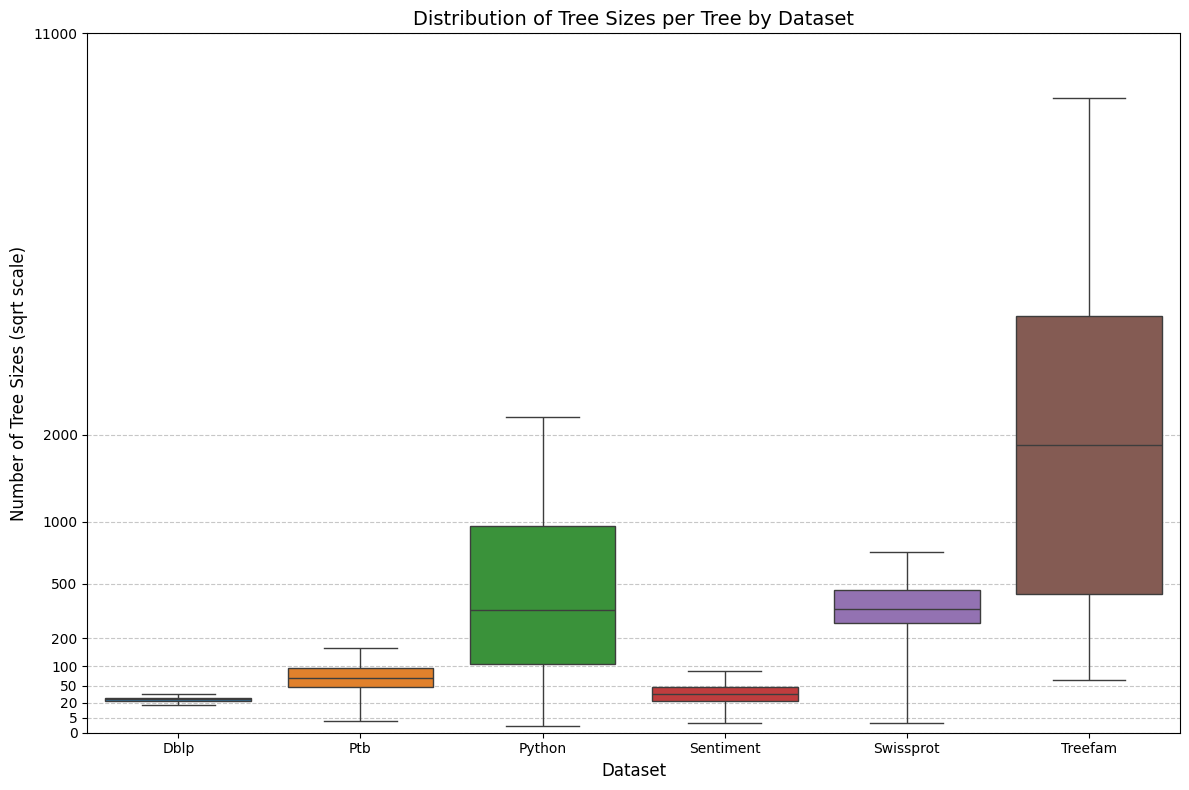

In [17]:
tree_sizes_stats = load_stats(datasets, 'tree_sizes')
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))
# Create boxplot with dataset as hue
ax = sns.boxplot(data=tree_sizes_stats, hue="Dataset", x='Dataset', y='tree_sizes', showfliers=False)
# Set the scale to sqrt using function-based scaling
ax.set_ylim(0, 11_000)
ax.set_yscale('function', functions=(np.sqrt, lambda x: x**2))
# Add customized yticks (starting from 5)
yticks = [0, 5, 20, 50, 100, 200, 500, 1000, 2000, 11_000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# Remove legend as it's redundant with x-axis labels
# ax.get_legend().remove()

# Customize the plot
ax.set_title('Distribution of Tree Sizes per Tree by Dataset', fontsize=14)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Tree Sizes (sqrt scale)', fontsize=12)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()


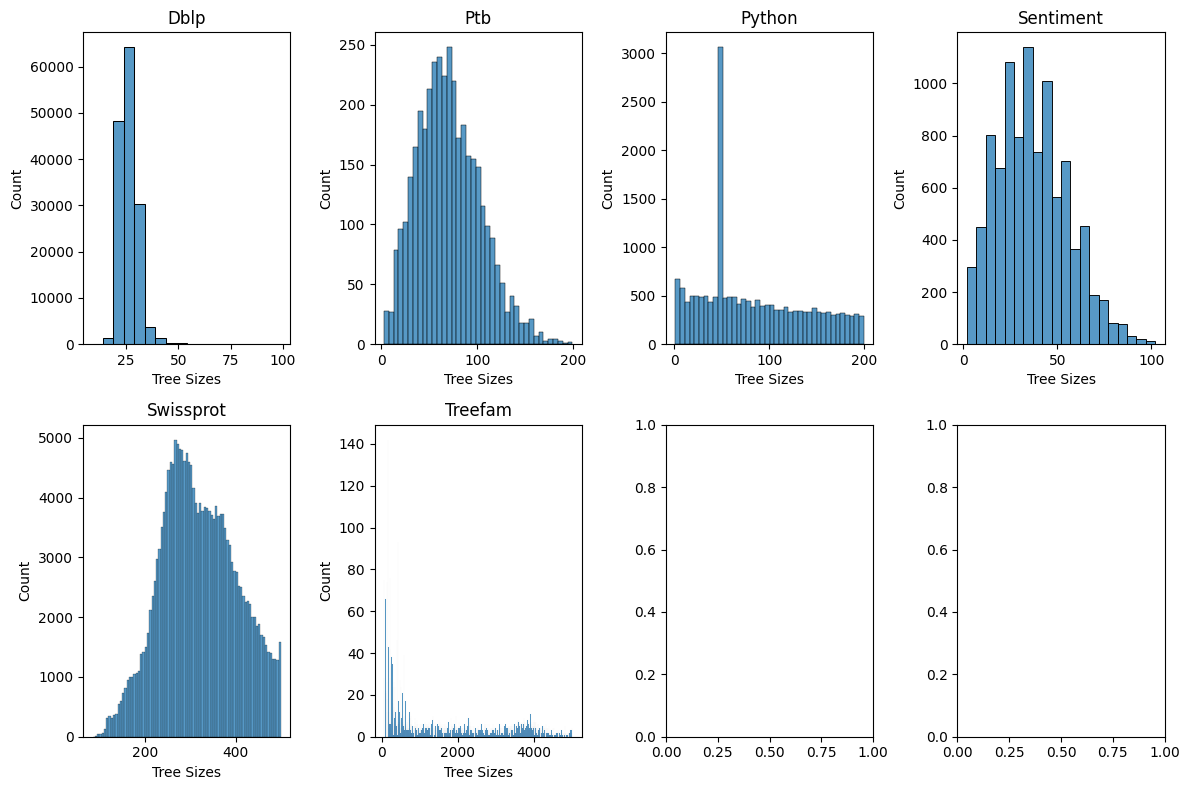

In [21]:
fix, axes = plt.subplots(2, 4, figsize=(12, 8))
down_thresholds = dict(
    swissprot=50,
)
up_thresholds = dict(
    bolzano=100,
    ptb=200,
    sentiment=150,
    treefam=5_000,
    rna=50,
    dblp=100,
    python=200,
    swissprot=500,
)


for ds, ax in zip(datasets, axes.ravel()):
    sns.histplot(
        tree_sizes_stats[(tree_sizes_stats['Dataset'] == ds.capitalize()) & (tree_sizes_stats['tree_sizes'].between(down_thresholds.get(ds, 0), up_thresholds[ds]))],
        x='tree_sizes', ax=ax, binwidth=5, cbar=True)
    ax.set_title(ds.capitalize())
    ax.set_xlabel('Tree Sizes')

plt.tight_layout()

In [ ]:
# Sort the DataFrame by 'tree_sizes' to ensure the rolling window operates correctly
# sizes_counts = sizes_counts.sort_values(by='tree_sizes')

# Apply a rolling window with a custom condition to sum counts within 5 tree_sizes
sizes_counts['rolling_sum'] = sizes_counts.rolling(window=5, min_periods=1, on='tree_sizes')['counts'].sum()

# Display the updated DataFrame
sizes_counts

,Dataset,tree_sizes,counts,rolling_sum
0,Bolzano,2,5,5.0
1,Bolzano,3,5,10.0
2,Bolzano,4,3,13.0
3,Bolzano,5,4,17.0
4,Bolzano,6,5,22.0
...,...,...,...,...
12290,Treefam,14730,1,5.0
12291,Treefam,14776,1,5.0
12292,Treefam,14837,1,5.0
12293,Treefam,14883,1,5.0


In [ ]:
def load_verification_times(dataset: str, threshold: int):
    runtime_df, absolute_df, lb_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    empty = True
    for lb_method in ALGORITHMS.keys():
        # print(lb_method)
        apted_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-apted-verification-times-ns.csv')
        topdiff_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-topdiff-verification-times-ns.csv')
    
        apted_df = pd.read_csv(apted_times, skiprows=2, names=["apted-verification-nanos"])
        topdiff_df = pd.read_csv(topdiff_times, skiprows=2, names=["topdiff-verification-nanos"])
        df = apted_df.join(topdiff_df).join(dataframes[dataset][lb_method][2])
        df['query_filter_time_nanos'] = df['query_filter_time_us'] * 1000
        
        df['lb_method'] = ALGORITHMS[lb_method]

        # runtime is in MS
        rtdf = pd.DataFrame.from_records([
            (
                (df['apted-verification-nanos'].sum() / 1000 / 1000),
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000),
                df['query_filter_time_us'].sum() / 1000,
                (df['apted-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                lb_method
            )
        ] , columns=['apted-candidates', 'topdiff-candidates', 'lb-runtime', 'apted-runtime', 'topdiff-runtime', 'lb_method'])
        
        v_vars=['apted-runtime', 'topdiff-runtime']
        
        # total_runtime = df.melt(
        #     value_vars=v_vars, id_vars=['lb_method'], var_name='verification-method', value_name='runtime'
        # )
        
        melted_absolute = df.melt(
            value_vars=['apted-verification-nanos', 'topdiff-verification-nanos'], id_vars=['lb_method'], var_name='verification-method', value_name='nanos'
        )

        melted_lb = df.melt(value_vars=['query_filter_time_us'], id_vars=['lb_method'], value_name='lb_time')
        
        if empty:
            runtime_df = rtdf
            absolute_df = melted_absolute
            lb_df = melted_lb
            empty = False
        else:
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            runtime_df = pd.concat([runtime_df, rtdf], ignore_index=True)
            absolute_df = pd.concat([absolute_df, melted_absolute], ignore_index=True)
            lb_df = pd.concat([lb_df, melted_lb], ignore_index=True)
        # df['lb-apted-perc'] = 100 - df['apted-perc']
        # df['lb-topdiff-perc'] =  100 - df['topdiff-perc'] 
    
    return runtime_df, absolute_df, lb_df
    ...

In [ ]:
runtime, melted_absolute, lb_df = load_verification_times('bolzano', 6)

KeyError: 'bolzano'

In [ ]:
humanfriendly.format_timespan(timedelta(milliseconds=3810159.25010))

NameError: name 'humanfriendly' is not defined

# Verification time (TED time) % of complete LB + verification time

The lower the verification time %, the faster the LB method was in comparison to verification by using
either exact TED (APTED) or using bounded-TED (topdiff)

In [ ]:
verification_times = []
for i, (ds, t) in enumerate(tested_values):
    print('Loading ', ds, ', t =', t, i)
    verification_times.append(load_verification_times(ds, t))

In [35]:
new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection", "Binary branch"]
# new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection"]

In [36]:
runtime, melted_absolute, lb_df = verification_times[-1]

display(runtime)

rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')
grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
grouped
# upper_bound = grouped['structural-variant'] + grouped['


IndexError: list index out of range

Loading  swissprot , t = 5 0


IndexError: list index out of range

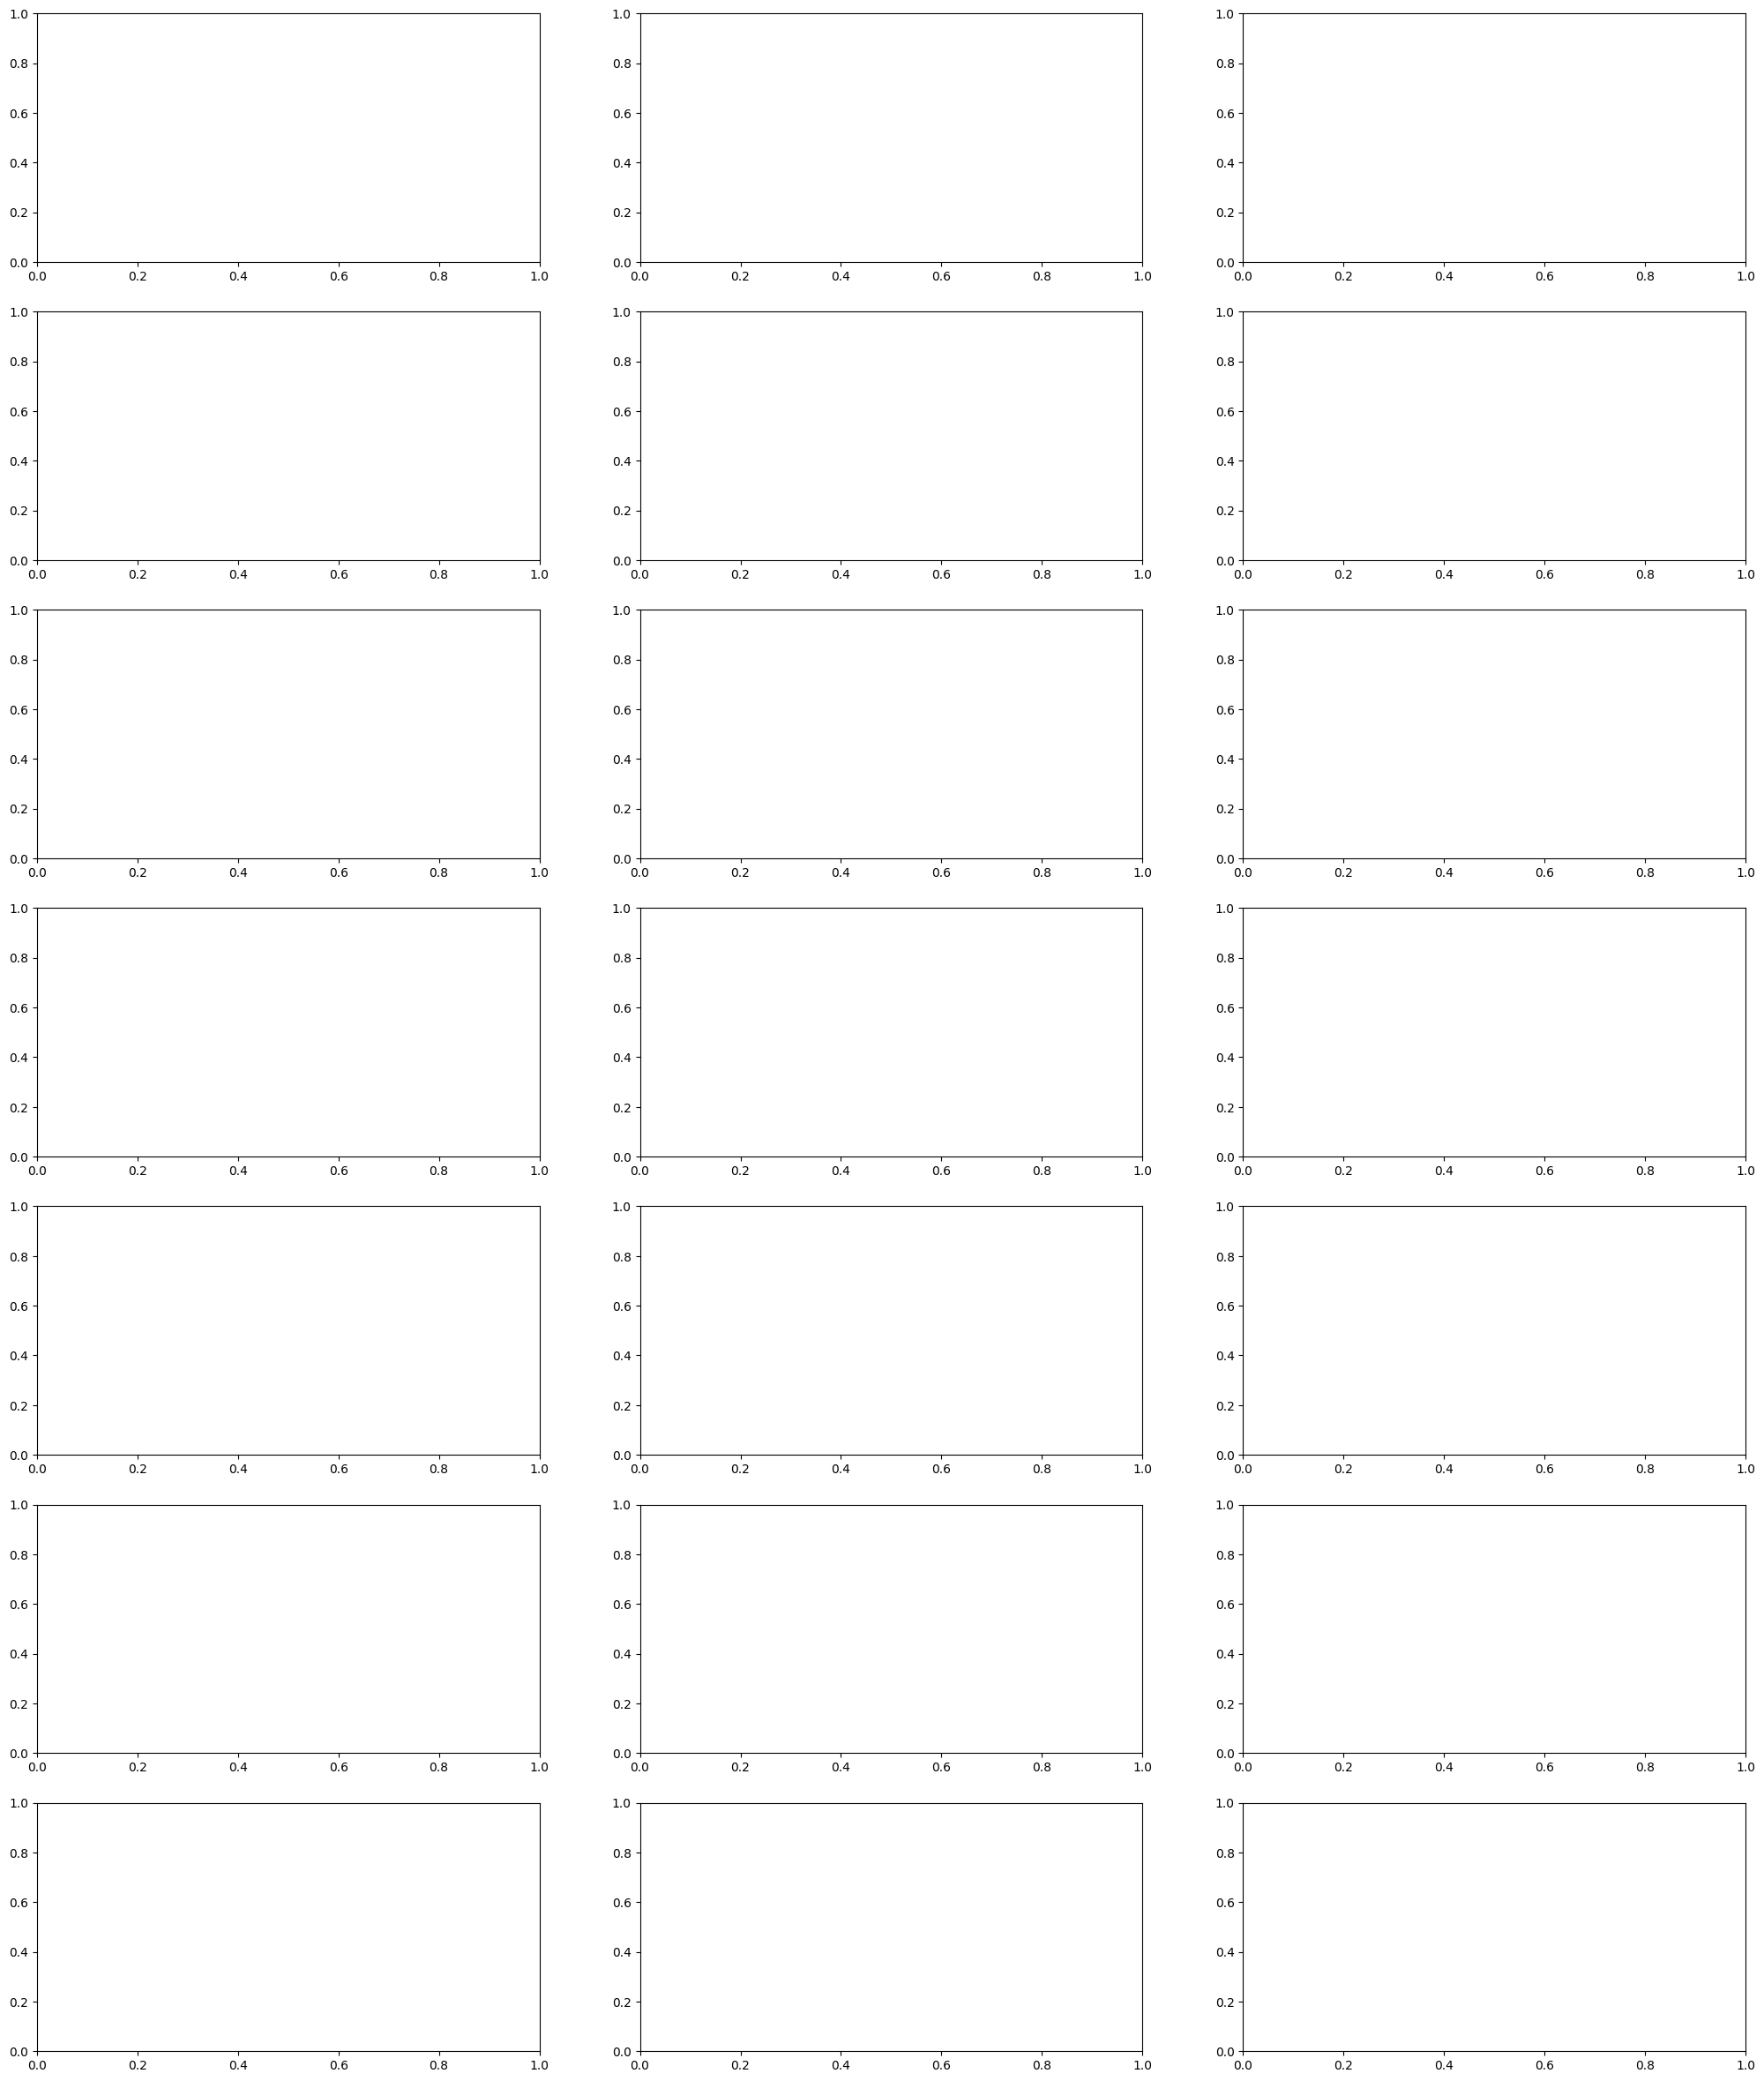

In [37]:
len_tested = len(tested_values)
fig, axes = plt.subplots(len_tested, 3, figsize=(25, 30))
# http://localhost:8888/lab/tree/TED-viz.ipynb#Verification-time-(TED-time)-%-of-complete-LB-+-verification-time
for i, (ds, t) in enumerate(tested_values[-1:]):
    print('Loading ', ds, ', t =', t, i)
    ###### Filter runtime #########
    runtime, melted_absolute, lb_df = verification_times[i]
    ofix, oax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=axes[i, 0])
    
    filter_boxplot = sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=oax)
    oax.set_title('LB filter time')
    oax.set_ylabel('Microseconds')
    oax.set_xlabel('LB filter')
    ofix.savefig(f"resources/plots/{ds}-filter-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)
    ofix, oax = plt.subplots(figsize=(10, 6))


    ###### Verification times #########
    # axes[i, 0].set_title('LB comp time in nanoseconds')
    sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=axes[i, 1])
    verif_plot = sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=oax)
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    axes[i, 1].set_title('TED verification in nanoseconds')
    oax.set_title('TED verification in nanoseconds')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')
    # sns.move_legend(axes[i, 1], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    
    ofix.savefig(f"resources/plots/{ds}-verification-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

    ###### Overall runtime #########
    ofix, oax = plt.subplots(figsize=(10, 6))
    rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')

    grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
    upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
    
    sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=axes[i, 2])
    axes[i, 2].set_ylim(0, upper_bound)
    runtime_fig = sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=oax)
    sns.move_legend(axes[i, 2], "upper left", bbox_to_anchor=(1, 1))
    axes[i, 2].set_title('Total runtime')
    axes[i, 2].set_ylabel('Total runtime with verification')

    # axes[i, 2].bar_label(axes[i, 2].containers[-1], label_type='center', rotation=90, color='white')

    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    oax.set_ylim(0, upper_bound)
    oax.set_title('Total runtime')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')

    lbl_type = 'center' if ds not in ('python', ) else 'edge'
    oax.bar_label(oax.containers[-1], label_type=lbl_type, rotation=90, color='black')
    if ds == 'treefam':
        oax.bar_label(oax.containers[-2], label_type='center', rotation=90, color='black')
    
    ofix.savefig(f"resources/plots/{ds}-overall-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

for ax, (ds, _) in zip(axes[:, 0], tested_values[-1:]):
    ax.set_ylabel(ds, size='large')

plt.tight_layout()
plt.show()

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(32, 11))
f.suptitle('Single tree to dataset search time in Microseconds, SPLIT=4')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)

    times_df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = ALGORITHMS[alg]
        times_df = pd.concat([times_df, times])
    bp = sns.boxplot(data=times_df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=times_df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

In [ ]:
times_df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        times_df = pd.concat([times_df, summary])
times_df
display(summary)
pivoted = times_df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
# sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(14, 8))
hp = sns.heatmap(pivoted, fmt='.1%', annot=True)
plt.yticks(rotation=0) 
plt.ylabel("Dataset", rotation=0, fontsize="large")
hp.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = True, labeltop=True)
fig.savefig("resources/plots/precision-heatmap.svg", format='svg')
hp.set(title='Precision heatmap, SPLIT=4')


In [38]:
summary = dataframes[ds][alg][1].copy()
summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
summary

KeyError: 'swissprot'

In [ ]:
times_df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
        summary = summary.astype({'Mean Selectivity': 'float64'})
        summary['Mean Selectivity'] = summary['Mean Selectivity'] / 100
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        times_df = pd.concat([times_df, summary])
pivoted = times_df.pivot(index="Dataset", columns="Algorithm", values="Mean Selectivity").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True, fmt='.2%')
hp.set(title='Selectivity heatmap, SPLIT=4')

KeyError: 'bolzano'

In [40]:
dataframes = dict()
tested_values = [('sentiment', 5), ('sentiment', 15), ('sentiment', 20), ('sentiment', 10)]
dataframes['sentiment'] = dict()
for ds, t in tested_values:
    dataframes[ds][t] = load_dataset(ds, t)

structural is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Structural-times-us.txt skipping
structural-variant is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-StructuralVariant-times-us.txt skipping
sed is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Sed-times-us.txt skipping
lblint is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Lblint-times-us.txt skipping
bib is not computed for sentiment resources/workloads/generated/base-25/sentiment/5/sentiment-Bib-times-us.txt skipping


KeyError: 'sedindex'

In [ ]:
times_df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds][x].keys():
        summary = dataframes[ds][x][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Threshold'] = x
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        times_df = pd.concat([times_df, summary])
times_df
display(summary)
pivoted = times_df.pivot(index="Algorithm", columns="Threshold", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Sentiment Precision heatmap, SPLIT=4')

KeyError: 5

In [42]:
selectivities = [('sentiment', 0.0746, 5), ('sentiment', 0.859, 10), ('sentiment', 3.04574, 15), ('sentiment', 8.496, 20)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,sentiment,0.075,5
1,sentiment,0.859,10
2,sentiment,3.046,15
3,sentiment,8.496,20


In [ ]:
times_df = pd.read_csv('./python-Structural-times-us.txt', header=None, names=["LB time"])

FileNotFoundError: [Errno 2] No such file or directory: './python-Structural-times-us.txt'

In [ ]:
times_df['LB time'].sum() / 1000 / 1000

KeyError: 'LB time'

In [ ]:
times_df = pd.read_csv('./resources/results/python/15/python-Structural-times-us.txt', header=None, names=["LB time"])

In [ ]:
times_df['LB time'].sum() / 1000 / 1000

186.34054999999998

# TED Search Start - precision

In [11]:
from os.path import join

In [12]:
datasets = [ds for ds, _ in tested_values if ds not in ['bolzano']]
datasets

['sentiment', 'ptb', 'treefam', 'python', 'dblp', 'swissprot']

In [13]:
ALGORITHMS

{'structural': 'Structural',
 'structural-variant': 'Splitted Structural',
 'sed': 'Sed',
 'lblint': 'Lbl-Int',
 'bib': 'Binary branch',
 'sedindex': 'Sed Index',
 'lblindex': 'Lbl-Int Index',
 'structuralindex': 'Structural Index'}

In [ ]:
times_df = pd.DataFrame()
candidates_df = pd.DataFrame()
for ds in datasets:
    times_path = join('resources/puser-results', ds, 'times.txt')
    t = pd.read_csv(times_path, delimiter=';')
    t = t.rename(columns=ALGORITHMS)
    times_df = pd.concat([times_df, t.head(1)])
    
    candidates_df = pd.concat([candidates_df, t.iloc[[1]]])
times_df = times_df.set_index('dataset')
candidates_df = candidates_df.set_index('dataset')
# display(df)
display(times_df.transpose())
display(candidates_df)

dataset,sentiment,ptb,treefam,python,dblp,swissprot
Lbl-Int Index,6,12,47,35,335,103
Lbl-Int,10,74,29,418,19659,12090
Sed Index,12,59,271,300,2110,1290
Sed,41,179,223,238,18244,17751
Structural Index,18,25,151,89,775,648
Structural,15,184,67,1018,21306,46511


,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural
dataset,,,,,,
sentiment,222,222,135,135,153,153
ptb,372,372,245,245,322,322
treefam,14075,14075,8055,8055,8268,8268
python,72288,72288,72288,72288,72288,72288
dblp,136180,136180,70641,70641,71750,71750
swissprot,6784,6784,4666,4666,6652,6652


In [88]:
['ahoj'] * 3

['ahoj', 'ahoj', 'ahoj']

In [ ]:
# precision dataframe
pdf = pd.DataFrame()
vdf = pd.DataFrame()
for ds in datasets:
    temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
    tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
    times_ = []
    methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
    for mtd in ('Lblint', 'Sed', 'Structural'):
        k = mtd.replace('Lblint', 'Lbl-Int')
        candidate_count = candidates_df[k][ds]
        verification_path = join('resources/puser-results', ds, f'{mtd}-verification.txt')
        with open(verification_path) as f:
            lines = f.read().split('\n')
        times = pd.Series([float(t) for t in lines[:candidate_count]])
        correct_results = lines[candidate_count:]
        precision =  (len(lines) - 1 - candidate_count) / candidate_count
        temp_df[mtd] = precision
        temp_df

        total_verification_time_ms = times.div(1000_000).sum()
        # twice for index version
        times_.extend([total_verification_time_ms, total_verification_time_ms])
        # print(ds, mtd, precision)
    # temp_df = pd.DataFrame()
    pdf = pd.concat([pdf, temp_df])
    vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])

pdf = pdf.set_index("dataset")
vdf.sort_values(['Method', 'Dataset'], inplace=True)
# display(pdf)
# display(vdf)


[Text(0.5, 1.0, 'Query search precision')]

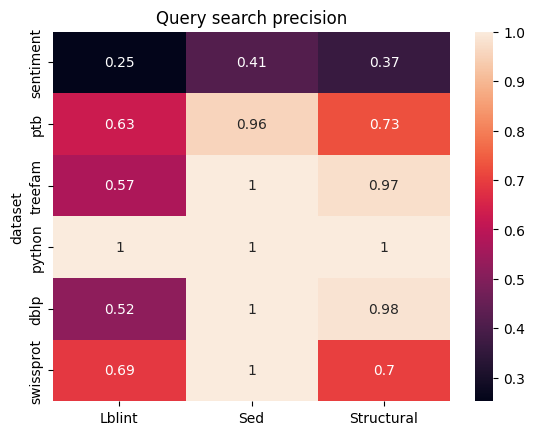

In [16]:
hp = sns.heatmap(data=pdf, annot=True)
hp.set(title='Query search precision')

# TED Search LB filters

Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


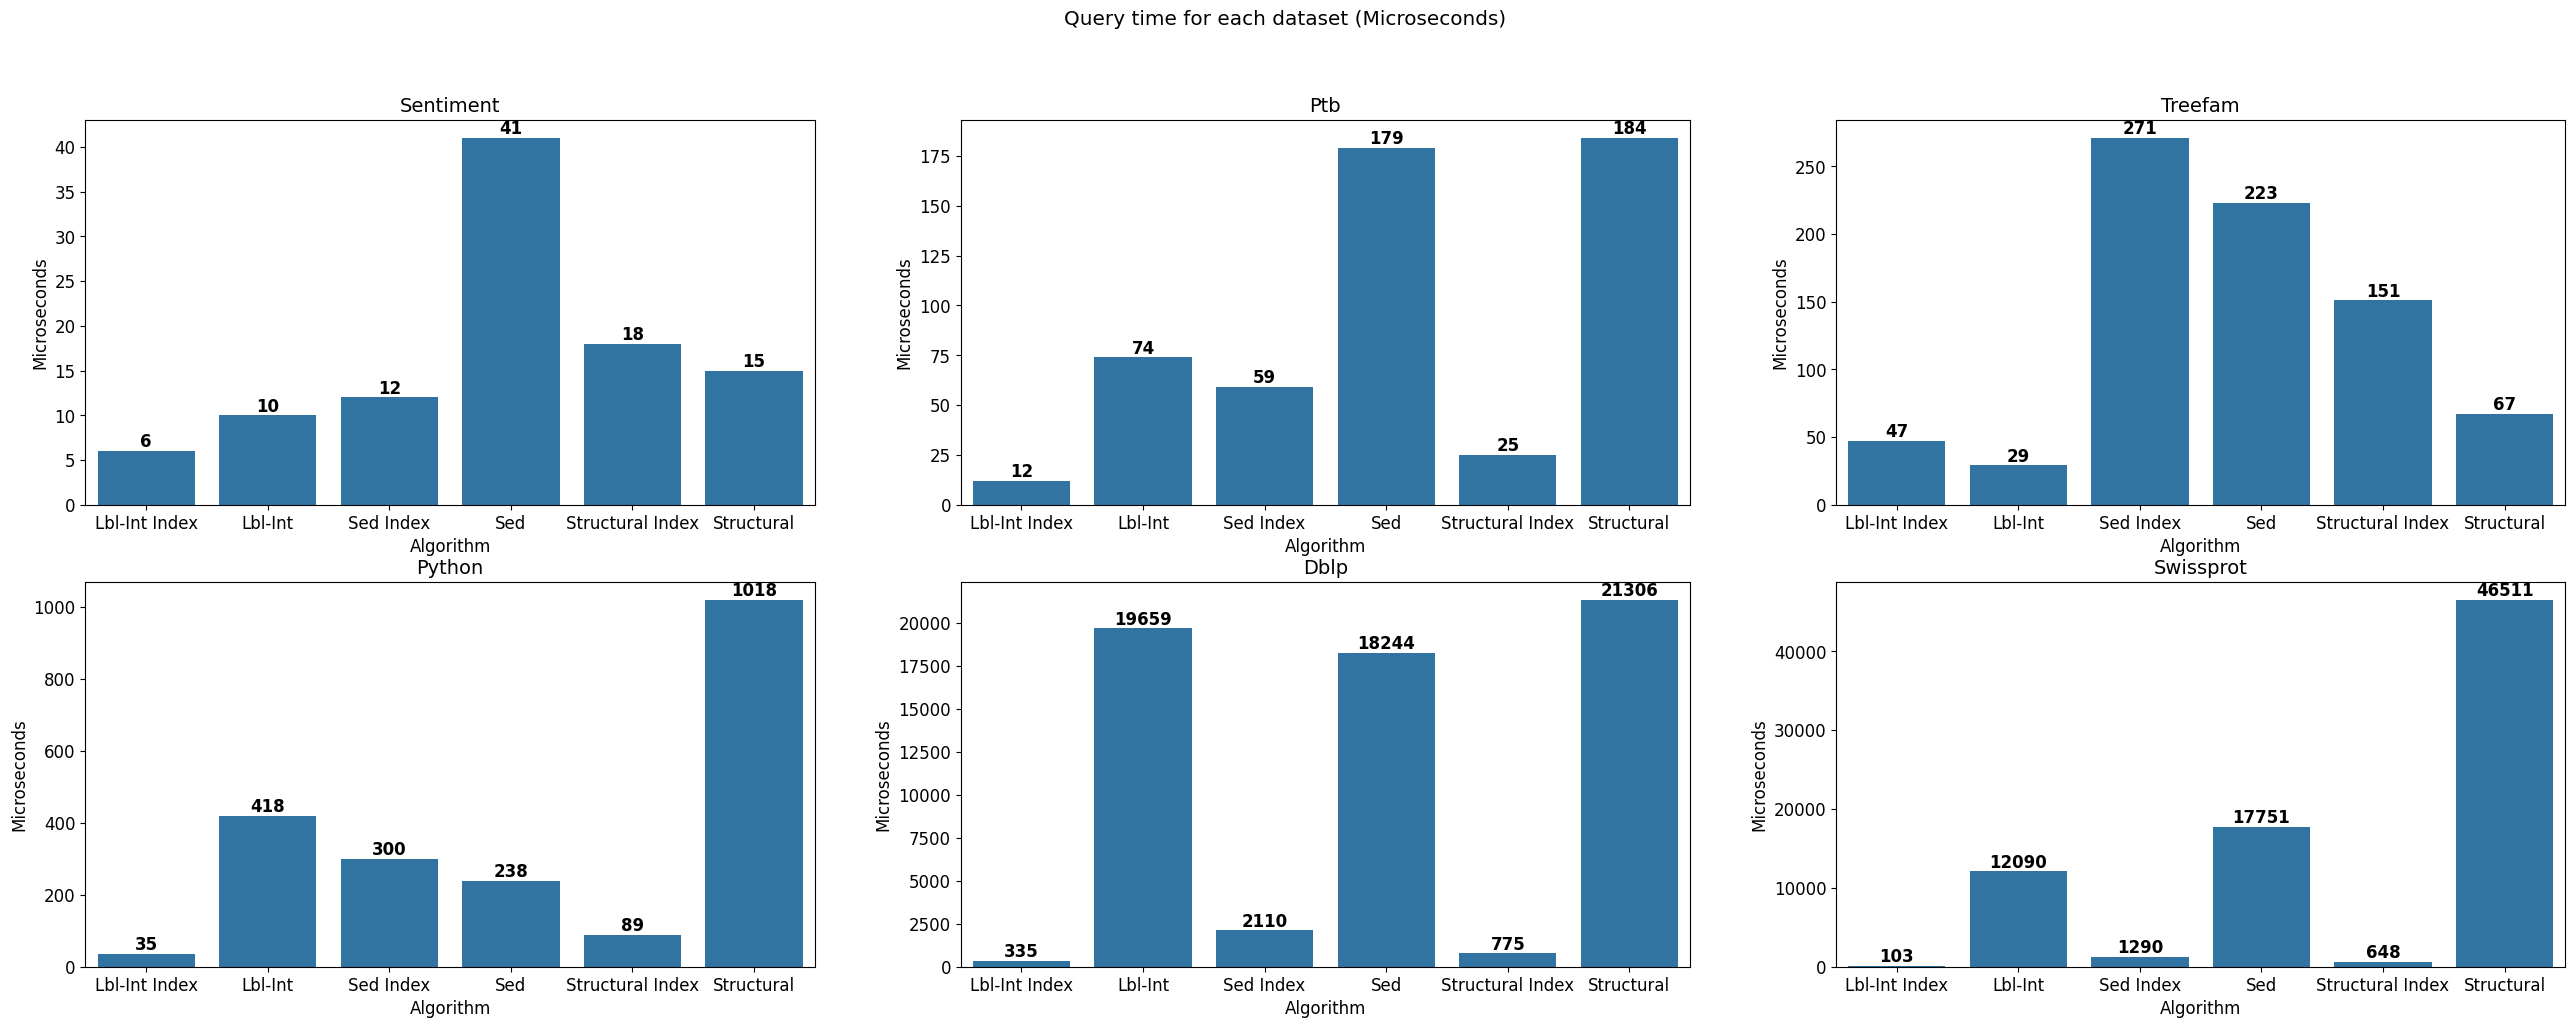

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
query_times_df = times_df.transpose()
f.suptitle('Query time for each dataset (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(query_times_df[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(query_times_df[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')


Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


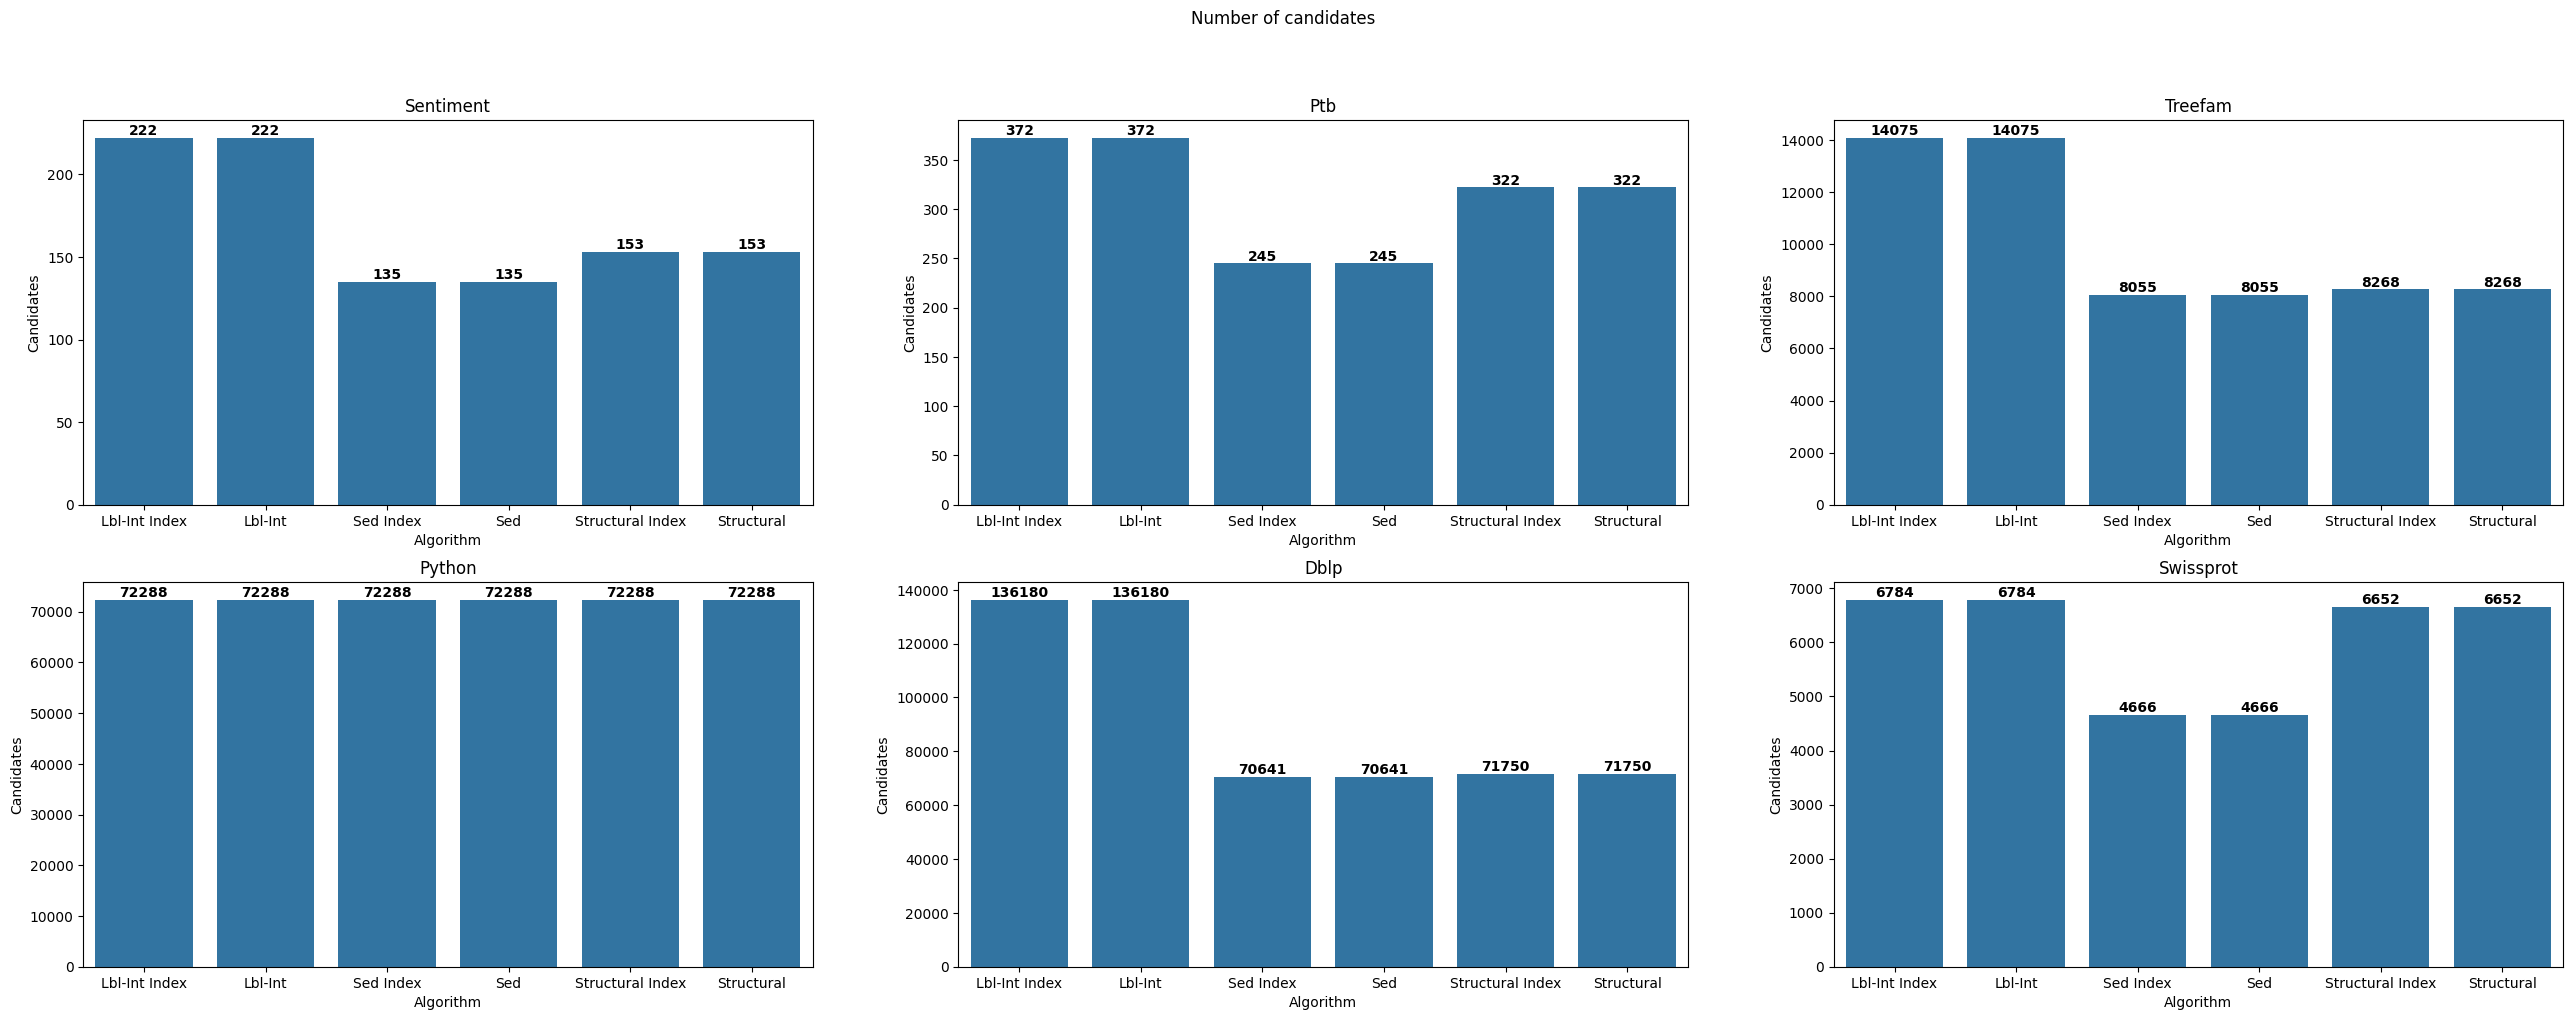

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
query_times_df = candidates_df.transpose()
f.suptitle('Number of candidates')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(query_times_df[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Candidates')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(query_times_df[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [ ]:
jdf = times_df.join(candidates_df, on='dataset', rsuffix='-candidates')

for alg in ALGORITHMS.values():
    if alg not in jdf:
        continue
    
    jdf[f'{alg}-ratio'] = round(jdf[f'{alg}'] / jdf[f'{alg}-candidates'], 4)

display(jdf.iloc[:, 12:])

,Structural-ratio,Sed-ratio,Lbl-Int-ratio,Sed Index-ratio,Lbl-Int Index-ratio,Structural Index-ratio
dataset,,,,,,
sentiment,0.098,0.304,0.045,0.089,2.700e-02,0.118
ptb,0.571,0.731,0.199,0.241,3.230e-02,0.078
treefam,0.008,0.028,0.002,0.034,3.300e-03,0.018
python,0.014,0.003,0.006,0.004,5.000e-04,0.001
dblp,0.297,0.258,0.144,0.030,2.500e-03,0.011
swissprot,6.992,3.804,1.782,0.277,1.520e-02,0.097


Printing  sentiment
Printing  ptb
Printing  treefam
Printing  python
Printing  dblp
Printing  swissprot


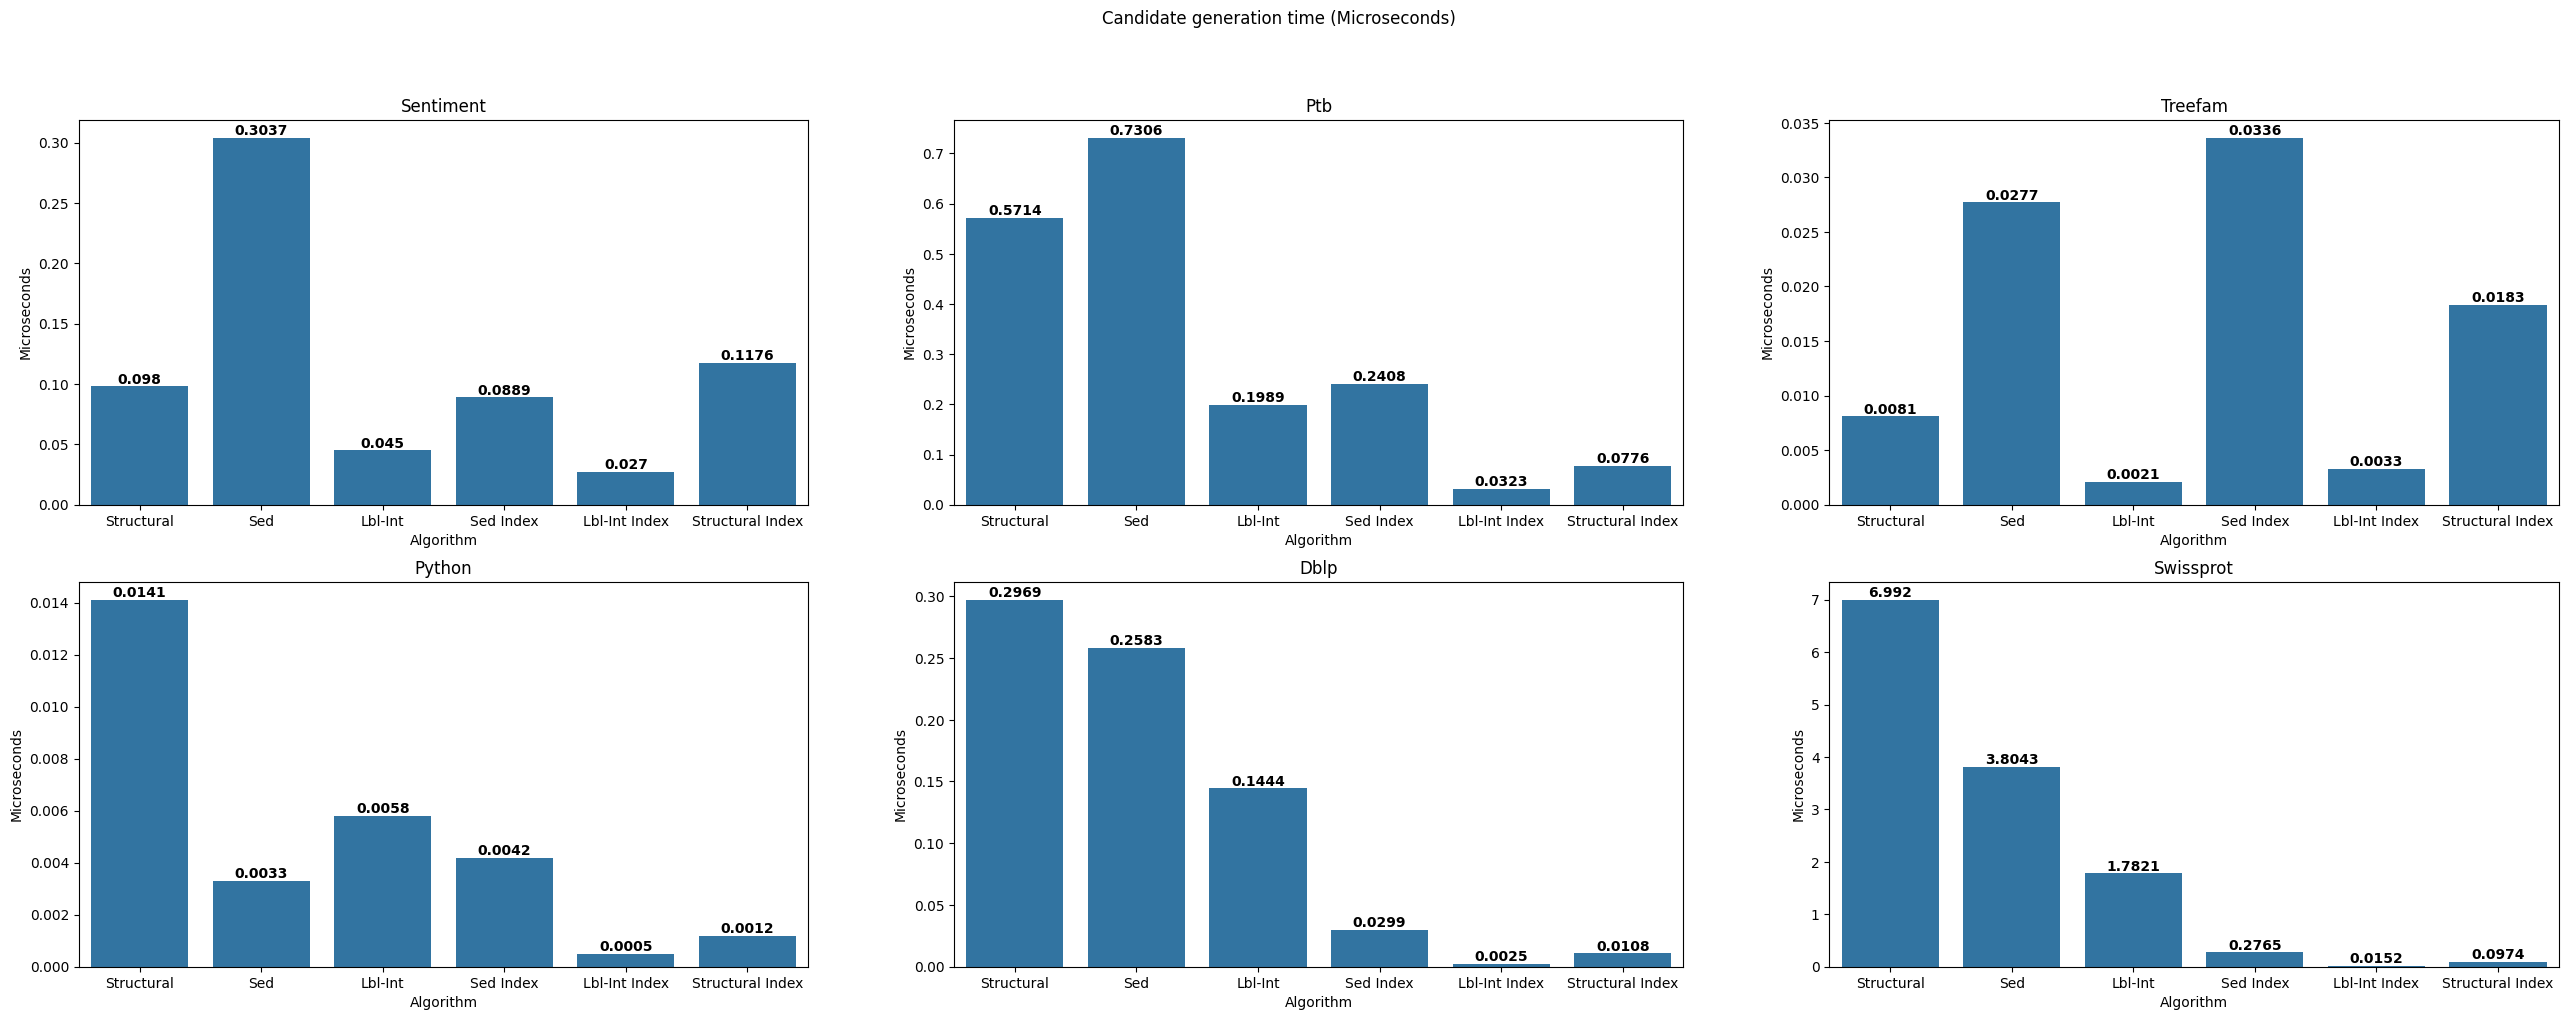

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
jdf = jdf.iloc[:, 12:].rename(mapper=lambda x: x.replace('-ratio', ''), axis=1)
query_times_df = jdf.transpose()
f.suptitle('Candidate generation time (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(query_times_df[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(query_times_df[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [ ]:
query_times_df['dblp']

Series([], Name: dblp, dtype: float64)

In [ ]:
times_df['Dataset'] = times_df.index

In [ ]:
times_df['process_part'] = 'searching'

In [204]:
vdf['process_part'] = 'verification'

In [ ]:
times_df

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural,Dataset,process_part
dataset,,,,,,,,
sentiment,6,10,12,41,18,15,sentiment,searching
ptb,12,74,59,179,25,184,ptb,searching
treefam,47,29,271,223,151,67,treefam,searching
python,35,418,300,238,89,1018,python,searching
dblp,335,19659,2110,18244,775,21306,dblp,searching
swissprot,103,12090,1290,17751,648,46511,swissprot,searching


In [ ]:
ldf = times_df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])

In [207]:
complete = pd.concat([ldf, vdf])

In [208]:
complete

,Dataset,process_part,Method,Time
0,sentiment,searching,Lbl-Int Index,6.000
1,ptb,searching,Lbl-Int Index,12.000
2,treefam,searching,Lbl-Int Index,47.000
3,python,searching,Lbl-Int Index,35.000
4,dblp,searching,Lbl-Int Index,335.000
...,...,...,...,...
4,ptb,verification,Structural Index,234.010
4,python,verification,Structural Index,9727.251
4,sentiment,verification,Structural Index,12.227
4,swissprot,verification,Structural Index,84109.027


In [20]:
import seaborn.objects as so

In [21]:
plot_data = complete.pivot_table(
    index=['Dataset', 'Method'],
    columns='process_part',
    values='Time'
).reset_index()

NameError: name 'complete' is not defined

In [22]:
plot_data

NameError: name 'plot_data' is not defined

In [82]:
from matplotlib.scale import ScaleBase

In [83]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# Search + Verification time plot for DS

NameError: name 'complete' is not defined

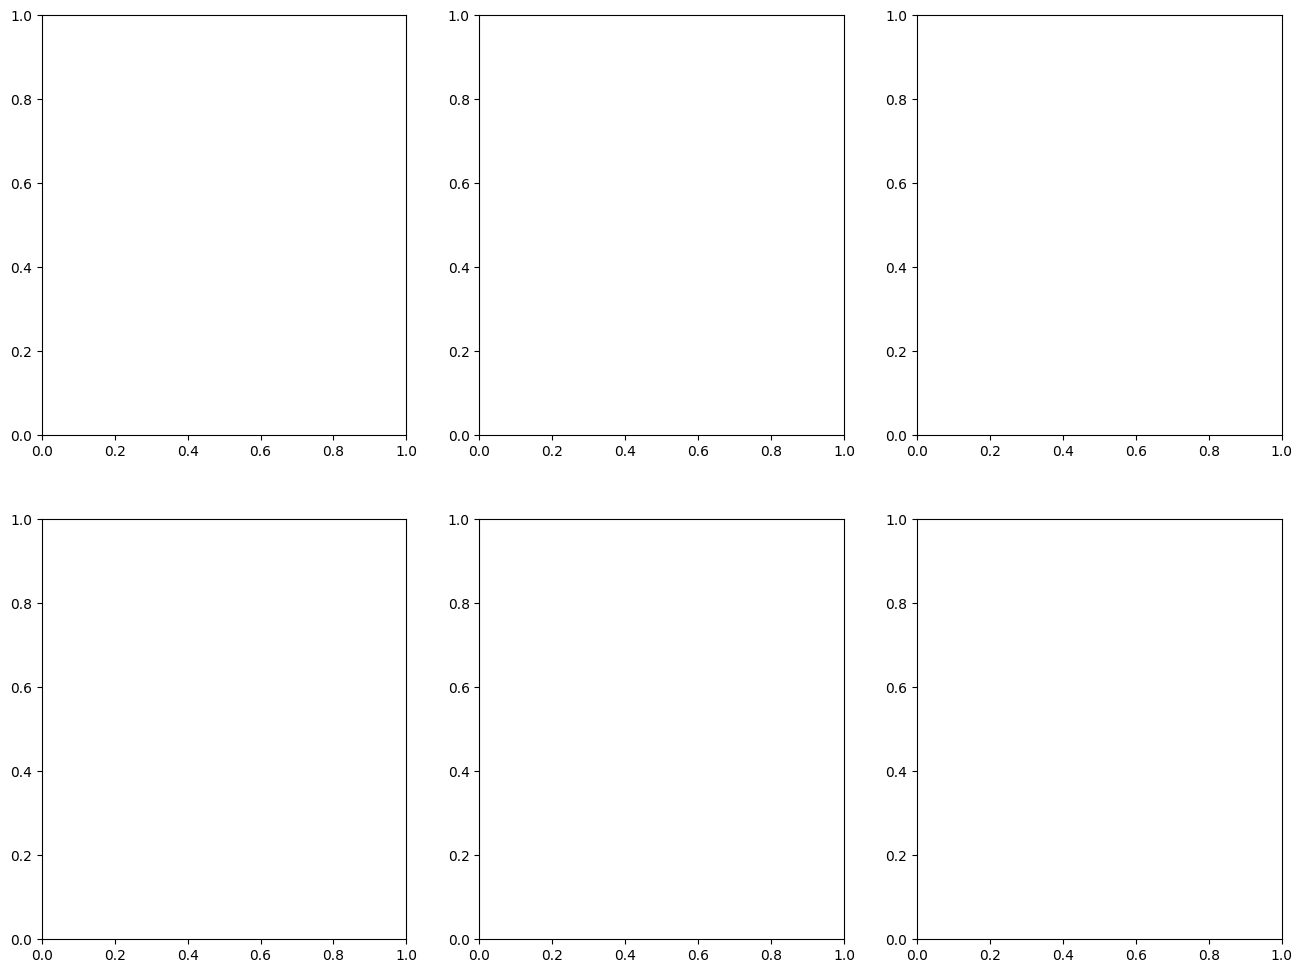

In [16]:
# Create subplot for each dataset
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
# Keep track of legend handles and labels
legend_handles = []
legend_labels = []
for dataset, ax in zip(complete['Dataset'].unique(), axes.ravel()):
    dataset_data = plot_data[plot_data['Dataset'] == dataset].set_index('Method')
    plot = dataset_data.drop('Dataset', axis=1).plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=False,
        title=dataset.capitalize(),
    )
    ax.set_xlabel('Method')
    ax.tick_params(axis='x', rotation=45)
    # Set sqrt scale
    # ax.set_yscale('log')
    ax.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
    ax.set_ylim(bottom=0)

    # Remove individual legends
    # ax.get_legend().remove()
    if dataset == complete['Dataset'].unique()[0]:
        legend_handles = plot.containers
        legend_labels = dataset_data.drop('Dataset', axis=1).columns

# Add single legend outside plots
fig.legend(
    legend_handles, 
    legend_labels,
    title='Process Parts',
    bbox_to_anchor=(1.05, 0.5),
    loc='center left'
)
# Adjust layout
plt.tight_layout()
plt.suptitle('Search time for method and datasets in ms (sqrt scale)')
# Add extra space for legend
plt.subplots_adjust(top=0.9, right=0.95)


# Show plot
plt.show()

# Dissimilarity

In [9]:
from os.path import join

In [10]:
from io import StringIO

In [11]:
tested_values

[('bolzano', 6),
 ('sentiment', 10),
 ('ptb', 15),
 ('treefam', 60),
 ('python', 15),
 ('dblp', 6),
 ('swissprot', 5)]

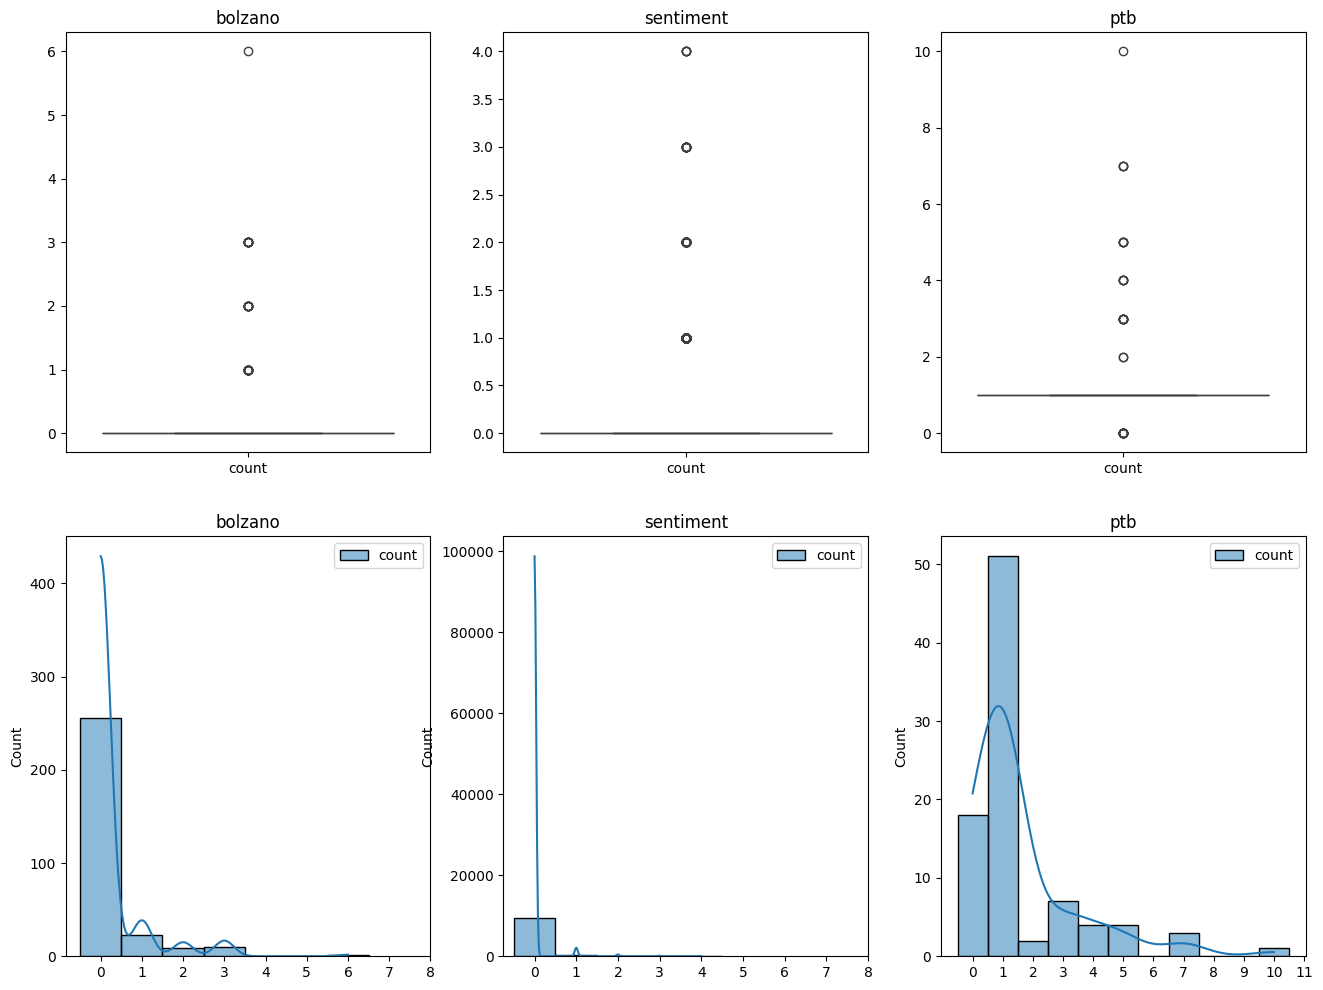

In [ ]:
BASEPATH = 'resources/puser-results/'
# tested_values = [('bolzano', 5)]

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

for i, (ds, _) in enumerate(tested_values[:3]):
    cfilename = join(BASEPATH, ds, 'dissimilarity', 'Structural_candidates.csv')
    with open(cfilename) as f:
        lines = f.readlines()
        lines_len = len(lines)
        lines = None
    
    vfilename = join(BASEPATH, ds, 'dissimilarity', 'verified.txt')
    with open(vfilename) as f:
        lines = f.readlines()
        actual = [l.strip() for l in lines[lines_len:]]
    times_df = pd.read_csv(StringIO('\n'.join(actual)), names=['T1', 'T2'])
    times_df = times_df.sort_values(by=['T1', 'T2'])
    # Filter rows where T1 != T2 and count T1
    filtered_counts = times_df[times_df['T1'] != times_df['T2']]['T1'].value_counts()
    # First count all occurrences of T1
    total_counts = times_df['T1'].value_counts()
    bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
    bp = sns.boxplot(bxdata, ax=axes[0][i])
    bp.set_title(ds)
    bxdata.head()
    hp = sns.histplot(bxdata, ax=axes[1][i], discrete=True, kde=True)
    hp.set_xticks(range(bxdata['count'].nunique() + 4))
    hp.set_title(ds)
    

In [15]:
tested_values

[('bolzano', 6),
 ('sentiment', 10),
 ('ptb', 15),
 ('treefam', 60),
 ('python', 15),
 ('dblp', 6)]

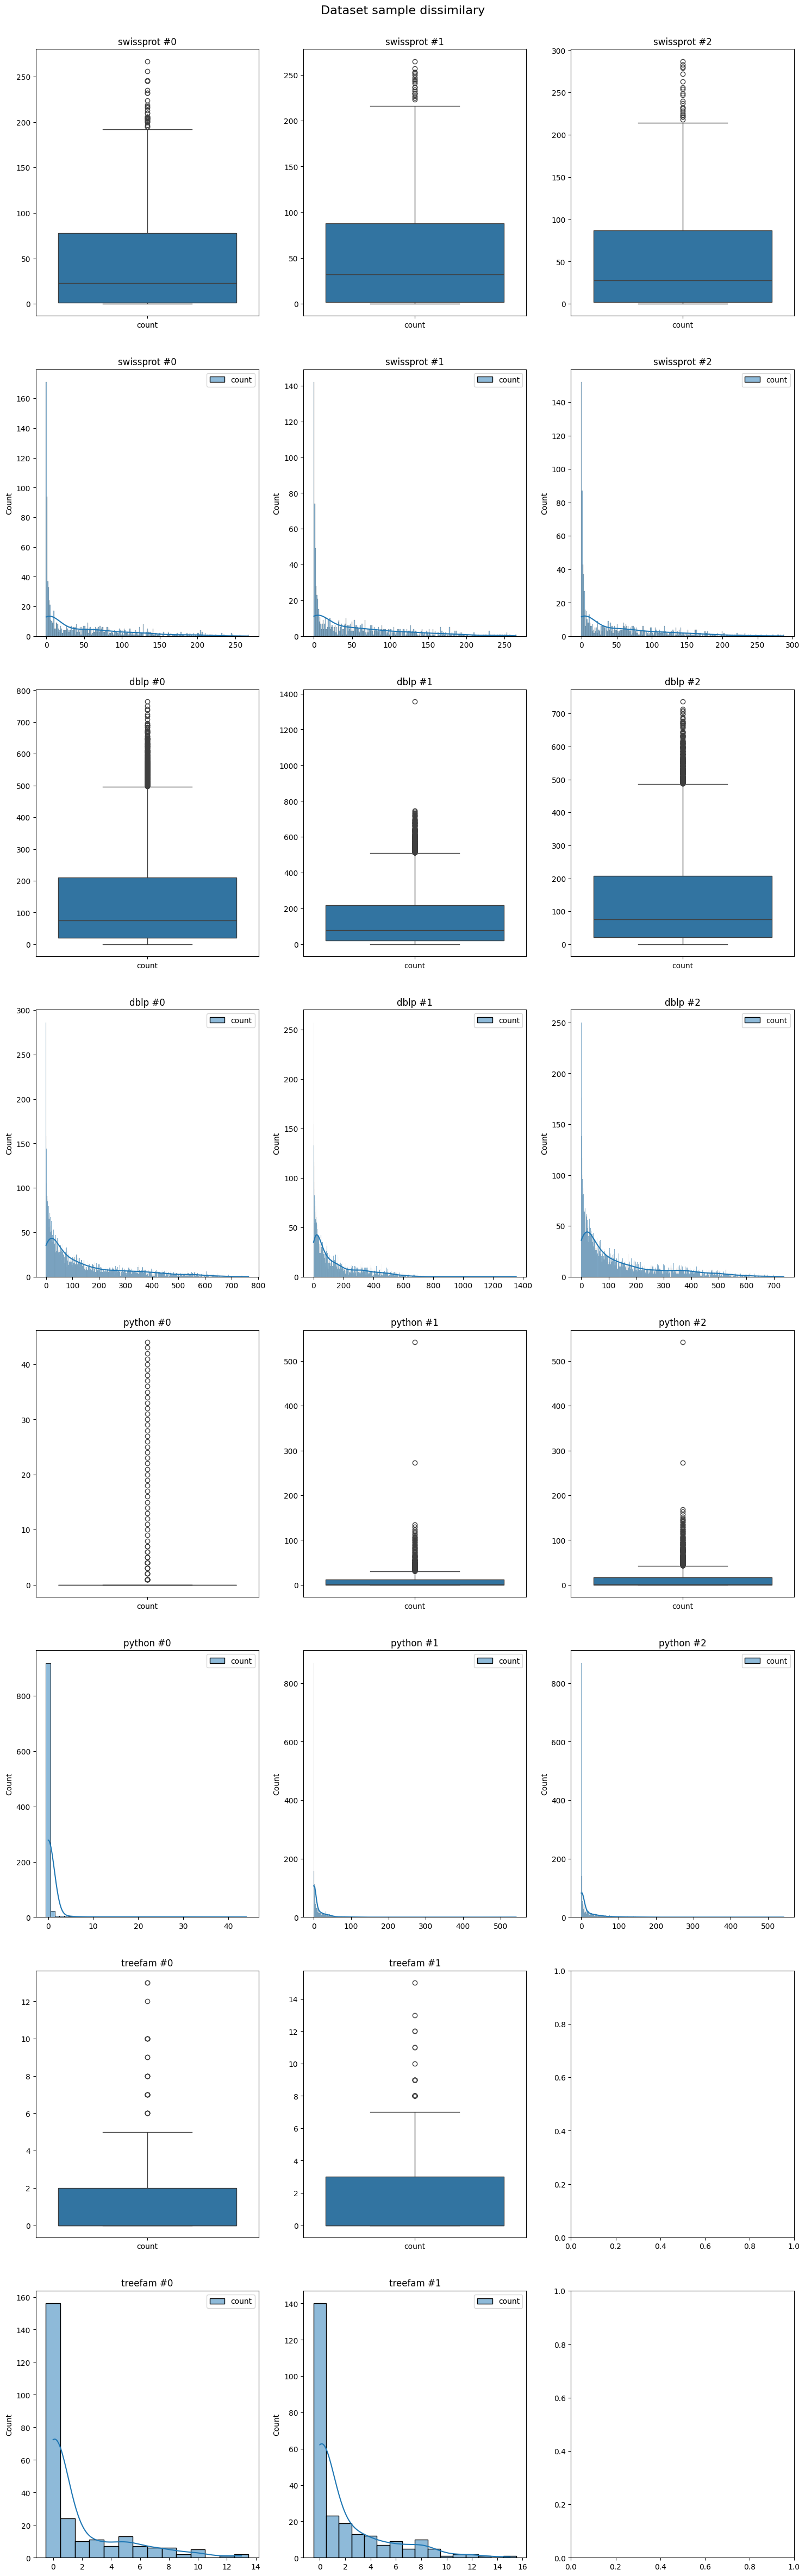

In [ ]:
BASEPATH = 'resources/dissimilarity/sample'
# tested_values = [('bolzano', 5)]

fig, axes = plt.subplots(8, 3, figsize=(18, 54))

for i, ds in enumerate(('swissprot', 'dblp', 'python', 'treefam')):
    s = i * 2
    max_results = 2 if ds == 'treefam' else 3
    for j in range(max_results):
        vfilename = join(BASEPATH, ds, str(j), 'verified.txt')
        with open(vfilename) as f:
            actual = [l for l in f if ',' in l]
        times_df = pd.read_csv(StringIO(''.join(actual)), names=['T1', 'T2'])
        times_df = times_df.sort_values(by=['T1', 'T2'])
        # Filter rows where T1 != T2 and count T1
        filtered_counts = times_df[times_df['T1'] != times_df['T2']]['T1'].value_counts()
        # First count all occurrences of T1
        total_counts = times_df['T1'].value_counts()
        bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
        bp = sns.boxplot(bxdata, ax=axes[s][j])
        bp.set_title(ds + f' #{j}')
        bxdata.head()
        hp = sns.histplot(bxdata, ax=axes[s + 1][j], discrete=True, kde=True)
        # hp.set_xticks(range(bxdata['count'].nunique() + 4))
        hp.set_title(ds + f' #{j}')
fig.suptitle('Dataset sample dissimilary', fontsize=16)
fig.subplots_adjust(top=0.965)

# Generated dissimilarity

In [22]:
from os.path import join
def get_query_runtime_for_df(basepath: str, ds: str):
    qt = join(basepath, ds, 'query_times.txt')
    # qt = f'resources/workloads/generated/{ds}/query_times.txt'
    with open(qt) as f:
        content = f.read()
    times = [l.split(':')[1].strip('ms') for i, l in enumerate(content.split('\n')) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content.split('\n')) if i % 3 == 2]
    methods = [l for i, l in enumerate(content.split('\n')) if i % 3 == 0 and l]
    csv_content = ','.join(methods) + '\n' +','.join(times)  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [23]:
pdf = pd.DataFrame()

d = get_query_runtime_for_df('resources/workloads/generated', 'base-25/lsmall')
d.iloc[[1]]
# pdf = pd.concat([pdf, d.loc[1]])
# display(pdf)

,Dataset,Lblint index,Lblint,Sed Index,Sed,Structural Index,Structural
1,base-25/lsmall,40000,40000,26402,26402,34472,34472


In [24]:
ALGORITHMS

{'structural': 'Structural',
 'structural-variant': 'Splitted Structural',
 'sed': 'Sed',
 'lblint': 'Lbl-Int',
 'bib': 'Binary branch',
 'sedindex': 'Sed Index',
 'lblindex': 'Lbl-Int Index',
 'structuralindex': 'Structural Index'}

In [ ]:
from os.path import join

bases = [f'base-{b}' for b in [25,50,100,200]]
datasets = [f'{base}/{x}' for x in ['lsmall', 'lmedium', 'lbig'] for base in bases]
times_df = pd.DataFrame()
candidates_df = pd.DataFrame()
for ds in datasets:
    query_times_df = get_query_runtime_for_df('resources/workloads/generated', ds)
    times_df = pd.concat([times_df, query_times_df.iloc[[0]]])
    candidates_df = pd.concat([candidates_df, query_times_df.iloc[[1]]])
            
times_df = times_df.rename(columns={
    'Lblint index': ALGORITHMS['lblindex'],
    'Lblint': ALGORITHMS['lblint'],
    'Sed Index': ALGORITHMS['sedindex'],
    'Sed': ALGORITHMS['sed'],
    'Structural Index': ALGORITHMS['structuralindex'],
    'Structural': ALGORITHMS['structural'],
    })
times_df = times_df.set_index('Dataset')
candidates_df = candidates_df.set_index('Dataset')
times_df['process_part'] = 'searching'
display(times_df)
display(candidates_df)
# df = pd.DataFrame()
# cdf = pd.DataFrame()
# for ds in datasets:
#     times_path = join('resources/puser-results', ds, 'times.txt')
#     t = pd.read_csv(times_path, delimiter=';')
#     t = t.rename(columns=ALGORITHMS)
#     df = pd.concat([df, t.head(1)])
    
#     cdf = pd.concat([cdf, t.iloc[[1]]])
# df = df.set_index('dataset')
# cdf = cdf.set_index('dataset')
# # display(df)
# display(df.transpose())
# display(cdf)

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural,process_part
Dataset,,,,,,,
base-25/lsmall,164,450,3811,3760,16,562,searching
base-50/lsmall,219,472,3864,3849,17,584,searching
base-100/lsmall,243,479,3850,3814,18,586,searching
base-200/lsmall,247,471,3780,3786,19,605,searching
base-25/lmedium,41,394,3891,3883,9,471,searching
base-50/lmedium,36,424,3800,3793,8,471,searching
base-100/lmedium,36,432,3916,3890,6,480,searching
base-200/lmedium,50,427,3791,3794,5,484,searching
base-25/lbig,26,387,3852,3860,9,458,searching


,Lblint index,Lblint,Sed Index,Sed,Structural Index,Structural
Dataset,,,,,,
base-25/lsmall,40000,40000,26402,26402,34472,34472
base-50/lsmall,20000,20000,14498,14498,17769,17769
base-100/lsmall,10000,10000,7458,7458,8978,8978
base-200/lsmall,5000,5000,4070,4070,4592,4592
base-25/lmedium,40000,40000,28526,28526,35589,35589
base-50/lmedium,20000,20000,14062,14062,17702,17702
base-100/lmedium,10000,10000,7270,7270,8982,8982
base-200/lmedium,5000,5000,4027,4027,4624,4624
base-25/lbig,40000,40000,28458,28458,35069,35069


In [13]:
ds = 'base-25/lsmall'
mtd = 'Sed'
verification_path = join('resources/workloads/generated', ds, f'{mtd.lower()}-verified.txt')
with open(verification_path) as f:
    lines = f.read().split('\n')
times = pd.Series([float(t) for t in lines if ',' not in t and t])
correct_results = [l for l in lines if ',' in l and l]

In [14]:
d = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])

In [15]:
d = d[d['T1'] != d['T2']].sort_values(by='T1')

In [ ]:
m = d.groupby('T1').count().mean(axis=0)

In [17]:
100 * ((m.reset_index()[0][0]) / 1000)

np.float64(1.687447257383966)

In [ ]:
pdf = pd.DataFrame()
vdf = pd.DataFrame()
selectivites = dict()
for ds in datasets:
    temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
    tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
    times_ = []
    methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
    for mtd in ('Lblint', 'Sed', 'Structural'):
        verification_path = join('resources/workloads/generated', ds, f'{mtd.lower()}-verified.txt')
        candidate_count = candidates_df[mtd][ds]
        
        with open(verification_path) as f:
            lines = f.read().split('\n')
        times = pd.Series([float(t) for t in lines if ',' not in t and t])
        correct_results = [l for l in lines if ',' in l and l]
        # candidate_count = 
        precision =  len(correct_results) / candidate_count
        # print(mtd, ds, candidate_count, len(correct_results))
        temp_df[mtd] = precision
        temp_df

        total_verification_time_ms = times.div(1_000_000).sum()
        # twice for index version
        times_.extend([total_verification_time_ms, total_verification_time_ms])
        # print(ds, mtd, precision)
    
    selectivity_df = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])
    selectivity_df = selectivity_df[selectivity_df['T1'] != selectivity_df['T2']].sort_values(by='T1')
    m = selectivity_df.groupby('T1').count().mean(axis=0)
    selectivity = 100 * ((m.reset_index()[0][0]) / 1000)
    selectivites[ds] = {'Selectivity':  selectivity }
    pdf = pd.concat([pdf, temp_df])
    vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
    

selectivity_df = pd.DataFrame.from_dict(selectivites)
pdf = pdf.set_index("dataset")
vdf.sort_values(['Method', 'Dataset'], inplace=True)


In [ ]:
selectivity_df['base-25/lsmall']['Selectivity']

np.float64(1.6963791267305646)

/tmp/ipykernel_192431/832719954.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bx.set_xticklabels(labels,


,base-25/lsmall,base-50/lsmall,base-100/lsmall,base-200/lsmall,base-25/lmedium,base-50/lmedium,base-100/lmedium,base-200/lmedium,base-25/lbig,base-50/lbig,base-100/lbig,base-200/lbig
Selectivity,1.696379,0.868923,0.4513,0.22888,1.655449,0.872315,0.443684,0.230676,1.645865,0.875307,0.438588,0.23244


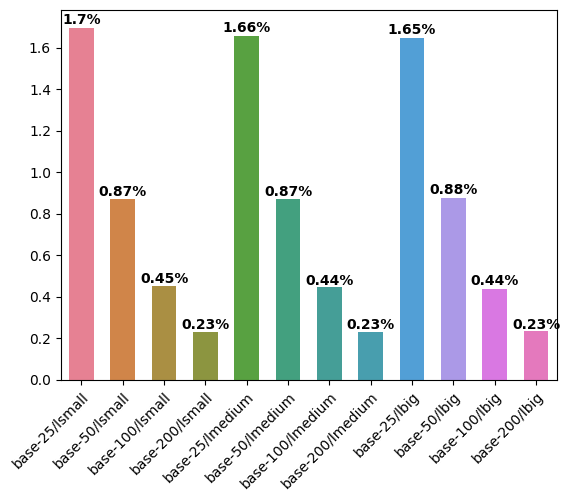

In [ ]:
# plt.figure(figsize=(18, 12))
bx = sns.barplot(selectivity_df, width=0.6)
# bx.tick_params(axis='x', rotation=45, rotation_mode='anchor'labelsize=10, ha='left')
labels = bx.get_xticklabels()
bx.set_xticklabels(labels, 
                   rotation=45,     # Rotation angle
                   ha='right',      # Horizontal alignment: 'left', 'center', or 'right'
                   rotation_mode='anchor')  # Ensures alignment works with rotation
display(selectivity_df)


# Add value annotations on top of each bar
for i, ds in enumerate(datasets):
    v = selectivity_df[ds]['Selectivity']
    bx.text(i, round(v, 2), str(round(v, 2)) + '%', 
            ha='center', va='bottom',  # horizontally centered, placed just above the bar
            fontweight='bold')

[Text(0.5, 1.0, 'Query search precision')]

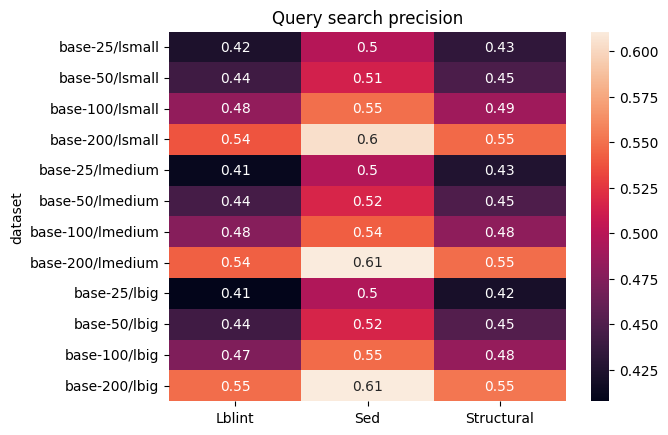

In [21]:
hp = sns.heatmap(data=pdf, annot=True)
hp.set(title='Query search precision')

Printing  base-25/lsmall
Printing  base-50/lsmall
Printing  base-100/lsmall
Printing  base-200/lsmall
Printing  base-25/lmedium
Printing  base-50/lmedium
Printing  base-100/lmedium
Printing  base-200/lmedium
Printing  base-25/lbig
Printing  base-50/lbig
Printing  base-100/lbig
Printing  base-200/lbig


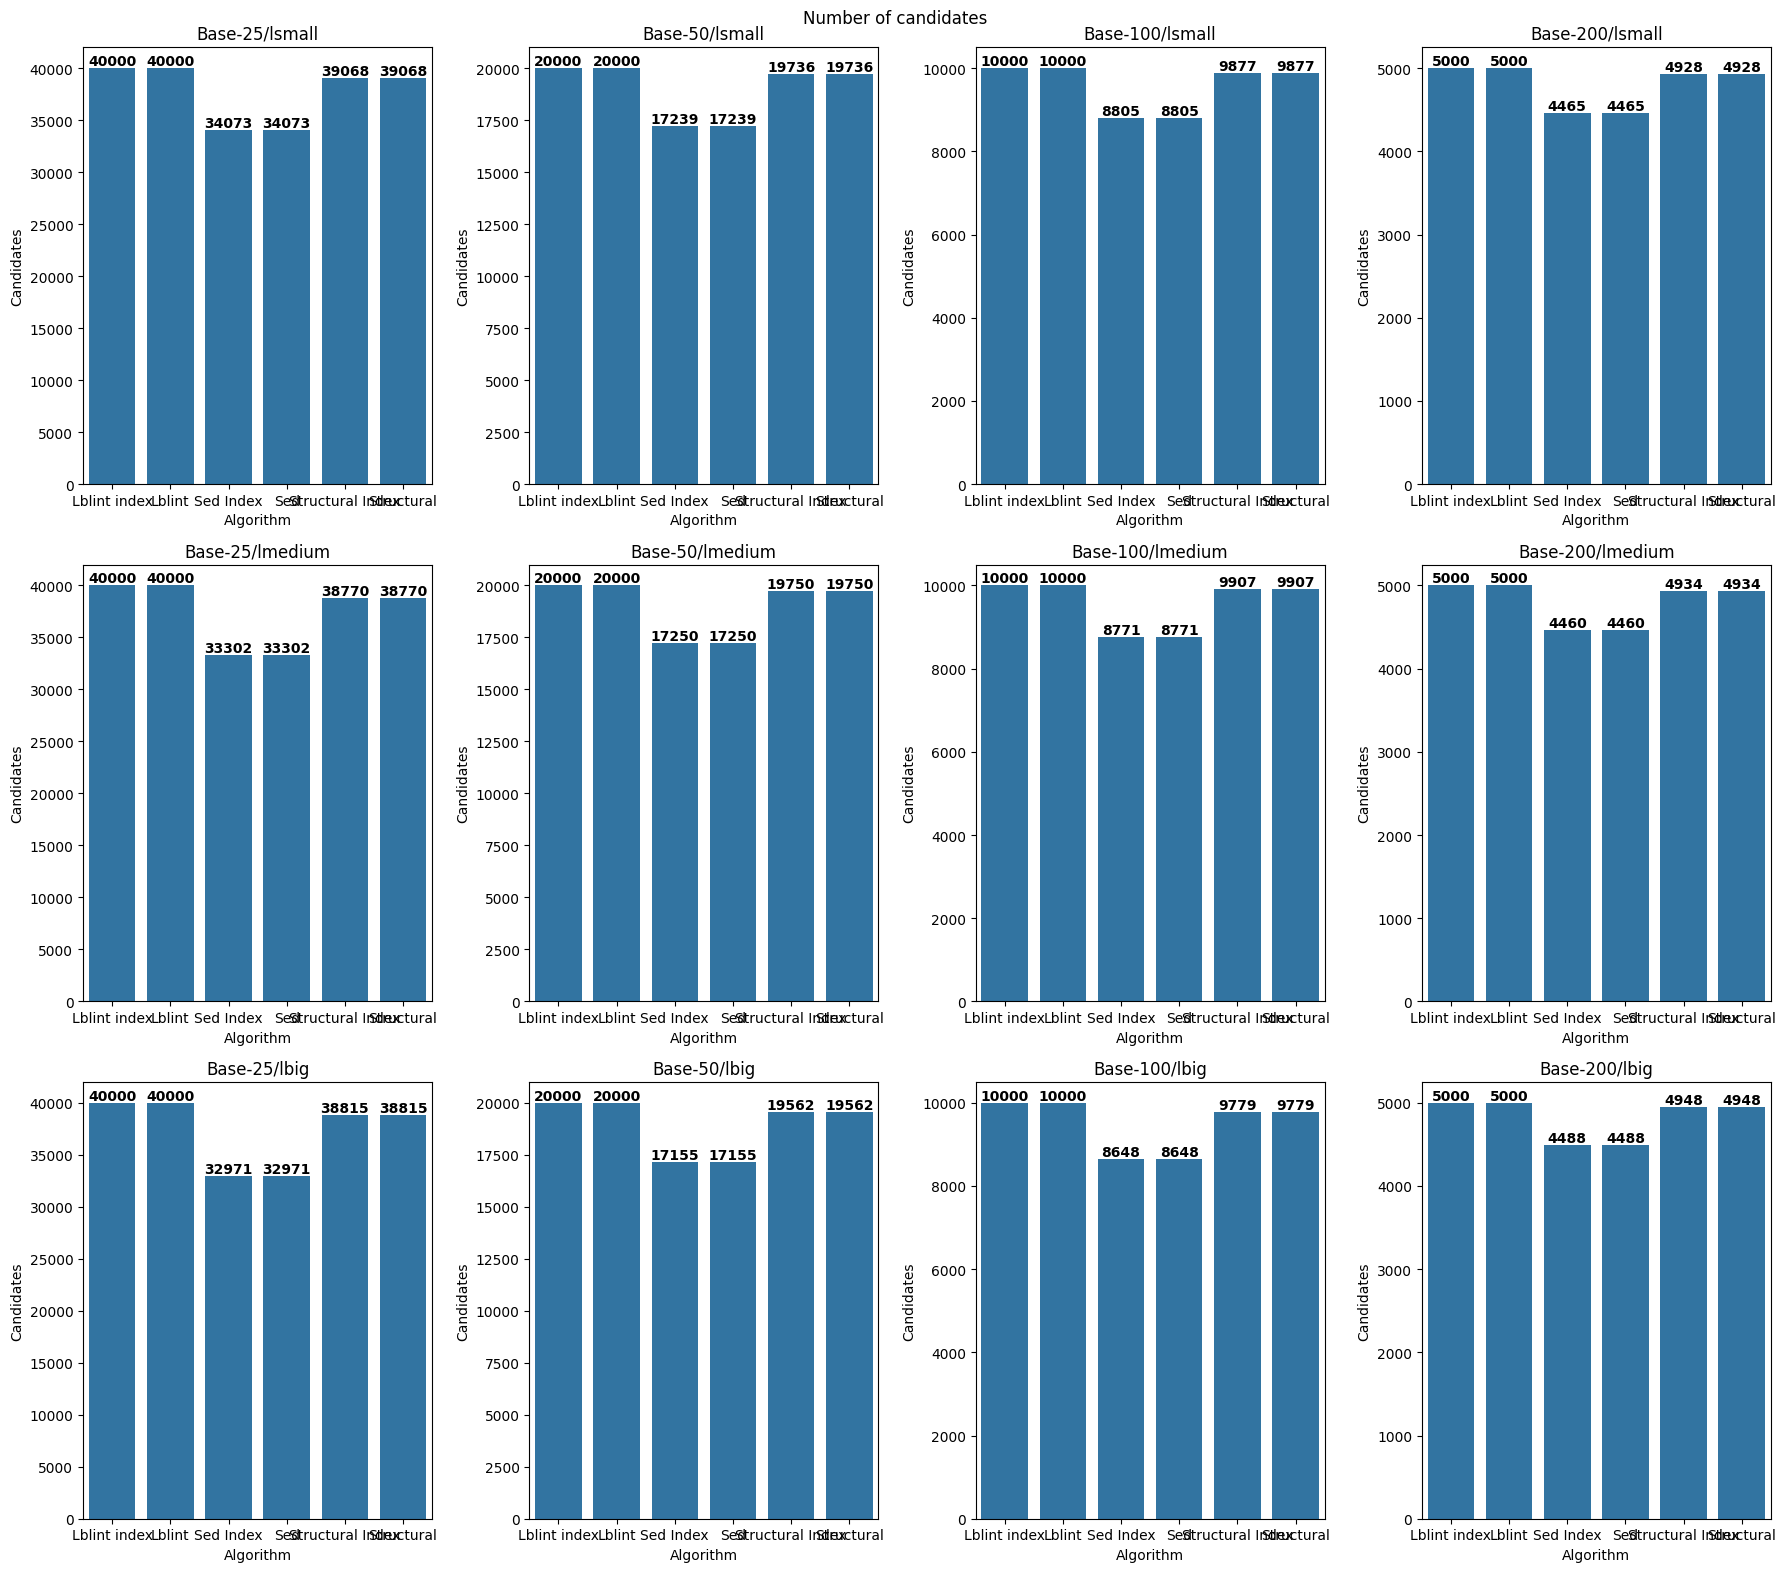

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(18, 16))
query_times_df = candidates_df.transpose()
f.suptitle('Number of candidates')

# Custom color palette

for ds, ax in zip(datasets, axes.ravel()):
    ax.set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(query_times_df[ds], ax=ax)
    bp.set(xlabel='Algorithm', ylabel='Candidates')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(query_times_df[ds]):
        ax.text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')
f.tight_layout()

In [ ]:
times_df['Dataset'] = times_df.index
ldf = times_df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])

In [24]:
complete = pd.concat([ldf, vdf])
complete

,Dataset,process_part,Method,Time
0,base-25/lsmall,searching,Lbl-Int Index,28.000000
1,base-50/lsmall,searching,Lbl-Int Index,21.000000
2,base-100/lsmall,searching,Lbl-Int Index,21.000000
3,base-200/lsmall,searching,Lbl-Int Index,19.000000
4,base-25/lmedium,searching,Lbl-Int Index,15.000000
...,...,...,...,...
4,base-25/lmedium,verification,Structural Index,29396.793258
4,base-25/lsmall,verification,Structural Index,32926.457392
4,base-50/lbig,verification,Structural Index,14853.649032
4,base-50/lmedium,verification,Structural Index,15243.627764


In [25]:
plot_data = complete.pivot_table(
    index=['Dataset', 'Method'],
    columns='process_part',
    values='Time'
).reset_index()

In [26]:
plot_data

process_part,Dataset,Method,searching,verification
0,base-100/lbig,Lbl-Int,207.0,7284.727860
1,base-100/lbig,Lbl-Int Index,7.0,7284.727860
2,base-100/lbig,Sed,4782.0,6257.381760
3,base-100/lbig,Sed Index,4671.0,6257.381760
4,base-100/lbig,Structural,299.0,7024.612397
...,...,...,...,...
67,base-50/lsmall,Lbl-Int Index,21.0,15960.504367
68,base-50/lsmall,Sed,4581.0,15288.261456
69,base-50/lsmall,Sed Index,4706.0,15288.261456
70,base-50/lsmall,Structural,323.0,15718.848709


In [27]:
BASEPATH = 'resources/workloads/generated/base-25'

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels
0,Lsmall,90,117,103.640,1000,0.145,47.354,2960
0,Lmedium,89,118,103.024,1000,5.243,49.930,9217
0,Lbig,92,119,105.537,1000,10.022,46.814,12135


,count,dataset
T1,,
0,38,lbig
1,32,lbig
2,37,lbig
3,0,lbig
4,27,lbig
...,...,...
995,4,lsmall
996,0,lsmall
997,2,lsmall


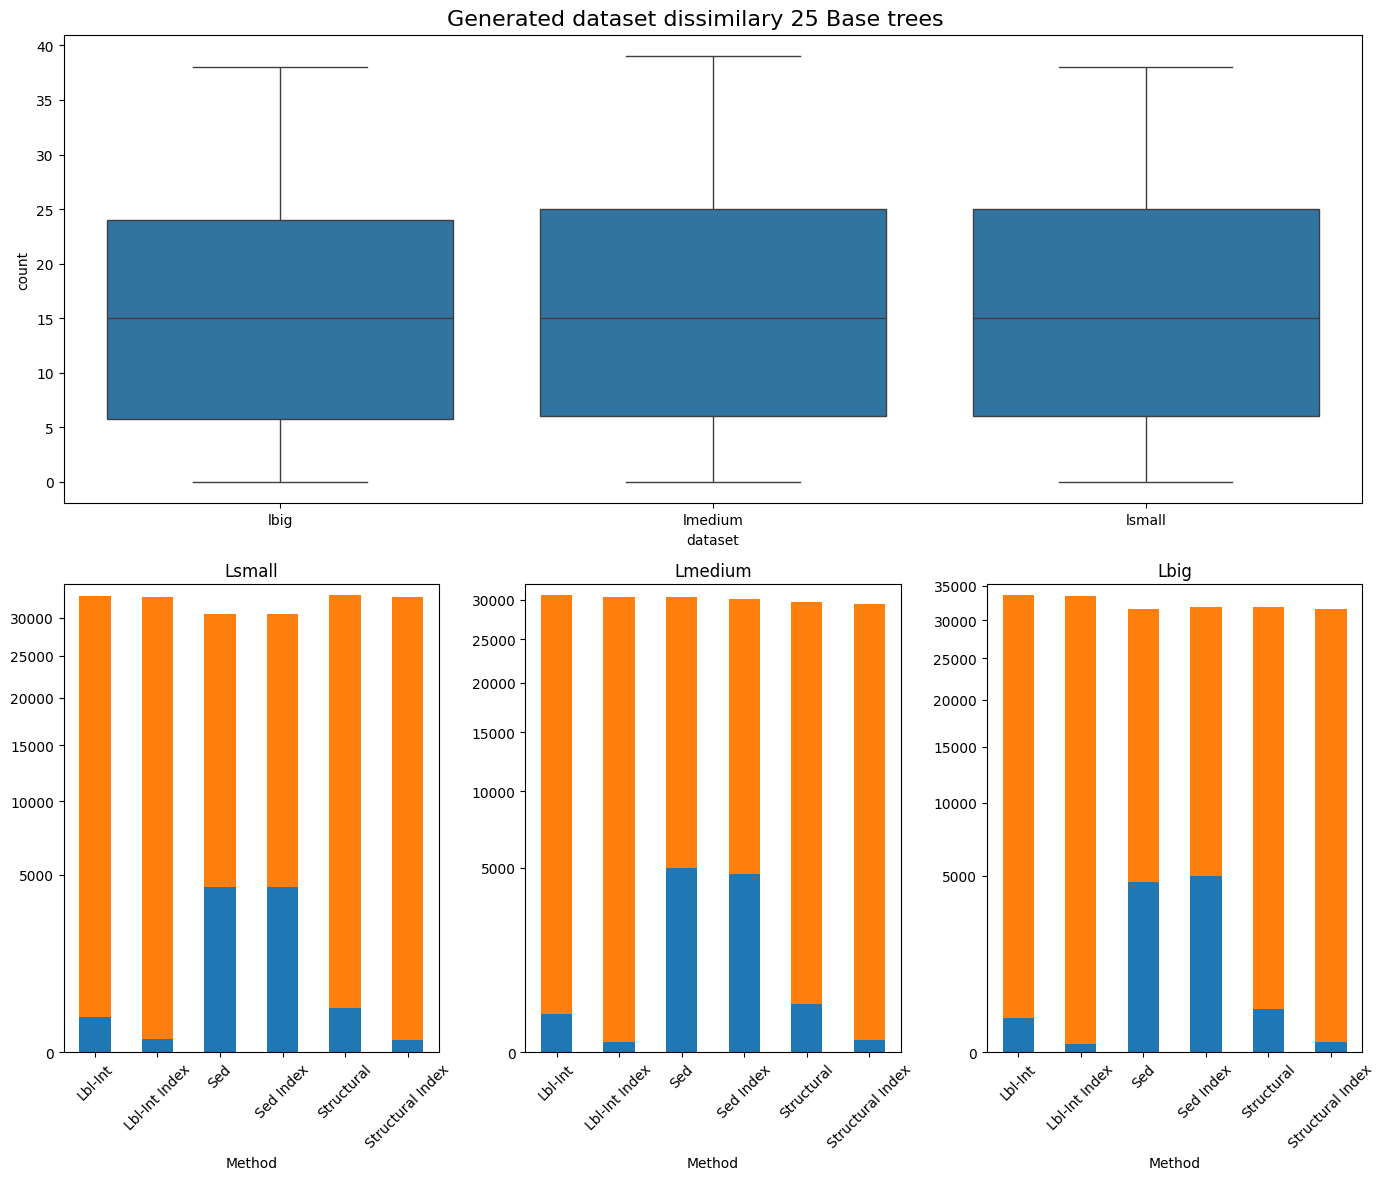

In [29]:
print_generated_dissimilar('resources/workloads/generated/base-25', '25 Base trees')

In [28]:
from os.path import dirname, basename, join
def print_generated_dissimilar(basepath: str, title = ''):
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(2, 3)
    ax0 = plt.subplot(gs[0, :])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[1, 1])
    ax3 = plt.subplot(gs[1, 2])
    axes = [[ax0], [ax1, ax2, ax3]]
    stats_df = pd.DataFrame()
    complete_bx_data = pd.DataFrame()
    complete_times_df = pd.DataFrame()
    
    for i, ds in enumerate(('lsmall', 'lmedium', 'lbig')):
        vfilename = join(basepath, ds, 'sed-verified.txt')
        df = pd.read_csv(join(basepath, ds, 'collection.csv'))
        df.insert(0, 'Dataset', [ds.capitalize()])
        stats_df = pd.concat([stats_df, df])
        with open(vfilename) as f:
            actual = [l for l in f if ',' in l]
        df = pd.read_csv(StringIO(''.join(actual)), names=['T1', 'T2'])
        df = df.sort_values(by=['T1', 'T2'])
        # Filter rows where T1 != T2 and count T1
        filtered_counts = df[df['T1'] != df['T2']]['T1'].value_counts()
        # First count all occurrences of T1
        total_counts = df['T1'].value_counts()
        bxdata = filtered_counts.reindex(total_counts.index, fill_value=0).reset_index().sort_values(by=['T1']).set_index('T1')
        bxdata['dataset'] = ds
        complete_bx_data = pd.concat([bxdata, complete_bx_data])
        # bp = sns.boxplot(bxdata, ax=axes[0][i])
        # bp.set_title(f'{ds.capitalize()} # similar trees')
        # bxdata.head()
        # hp = sns.histplot(bxdata, ax=axes[1][i], discrete=True, kde=True)
        # hp.set_xticks(range(bxdata['count'].nunique() + 4))
        # hp.set_title(f'{ds.capitalize()} # similar trees')
        # used for total query time
        plot_ds_name = join(basename(basepath), ds)
        dataset_data = plot_data[plot_data['Dataset'] == plot_ds_name].set_index('Method')
        ax = axes[1][i]
        # complete_times_df = pd.concat([complete_times_df, dataset_data
        plot = dataset_data.drop('Dataset', axis=1).plot(
            kind='bar',
            stacked=True,
            ax=ax,
            legend=False,
            title=ds.capitalize(),
        )
        ax.set_xlabel('Method')
        ax.tick_params(axis='x', rotation=45)
        # Set sqrt scale
        # ax.set_yscale('log')
        ax.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
        ax.set_ylim(bottom=0)
    
        # qdf = get_query_runtime_for_df(basepath, ds)
        # bx = sns.barplot(qdf, ax=axes[2][i])
        # bx.set_title(f'{ds.capitalize()} query times (ms)')
        # axes[2][i].set_yscale('log')
        # # axes[2][i].set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
        # bx.tick_params('x', rotation=45)
        # for ix in bx.containers:
        #     bx.bar_label(ix, padding=2)
    sns.boxplot(data=complete_bx_data, x = "dataset", y = "count", ax=ax0)
    fig.suptitle('Generated dataset dissimilary ' + title, fontsize=16)
    stats_df = stats_df.rename(columns={
        'min_tree': 'Min tree size',
        'max_tree': 'Max tree size',
        'avg_tree': 'Average tree size',
        'tree_count': 'Trees',
        'avg_unique_labels_per_tree': 'Avg. unique labels for a tree',
        'avg_tree_distinct_labels': 'Avg. distinct labels in tree',
        'distinct_labels': 'No. of distinct labels',
        'trees': 'No. of trees in dataset',
    })
    plt.tight_layout()
    
    display(stats_df)
    return complete_bx_data
    # fig.subplots_adjust(top=0.965)

In [30]:
def version_key(x):
    size_int = {'lbig': 10, 'lmedium': 5, 'lsmall': 1}
    # Split version string and convert to integers
    def int_of_ds(ds_name):
        base, size = ds_name.split('/')
        bs = int(base.split('-')[1])
        return bs + size_int[size]
    
    # v = pd.Series([int(n) for n in x.str.extract('(\d+)')[0]])
    v = pd.Series(
        [int_of_ds(n) for n in x.array]
    )
    print(v)
    return v


In [31]:
alldf = pd.melt(plot_data, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")

In [32]:
print(alldf[alldf['time'] == 0])

Empty DataFrame
Columns: [Dataset, Method, process_part, time]
Index: []


In [33]:
alldf.sort_values('process_part', ascending=False)

,Dataset,Method,process_part,time
72,base-100/lbig,Lbl-Int,verification,7284.727860
99,base-200/lmedium,Sed Index,verification,2848.510404
93,base-200/lbig,Sed Index,verification,2888.028868
94,base-200/lbig,Structural,verification,3235.974224
95,base-200/lbig,Structural Index,verification,3235.974224
...,...,...,...,...
49,base-25/lsmall,Lbl-Int Index,searching,28.000000
50,base-25/lsmall,Sed,searching,4318.000000
51,base-25/lsmall,Sed Index,searching,4333.000000
52,base-25/lsmall,Structural,searching,305.000000


In [34]:
alldf.index

RangeIndex(start=0, stop=144, step=1)

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels
0,Lsmall,90,120,103.799,1000,0.113,47.575,2981
0,Lmedium,90,118,102.998,1000,4.875,46.481,9168
0,Lbig,89,117,102.960,1000,9.368,48.472,12338


,count,dataset
T1,,
0,14,lbig
1,13,lbig
2,16,lbig
3,18,lbig
4,16,lbig
...,...,...
995,0,lsmall
996,2,lsmall
997,1,lsmall


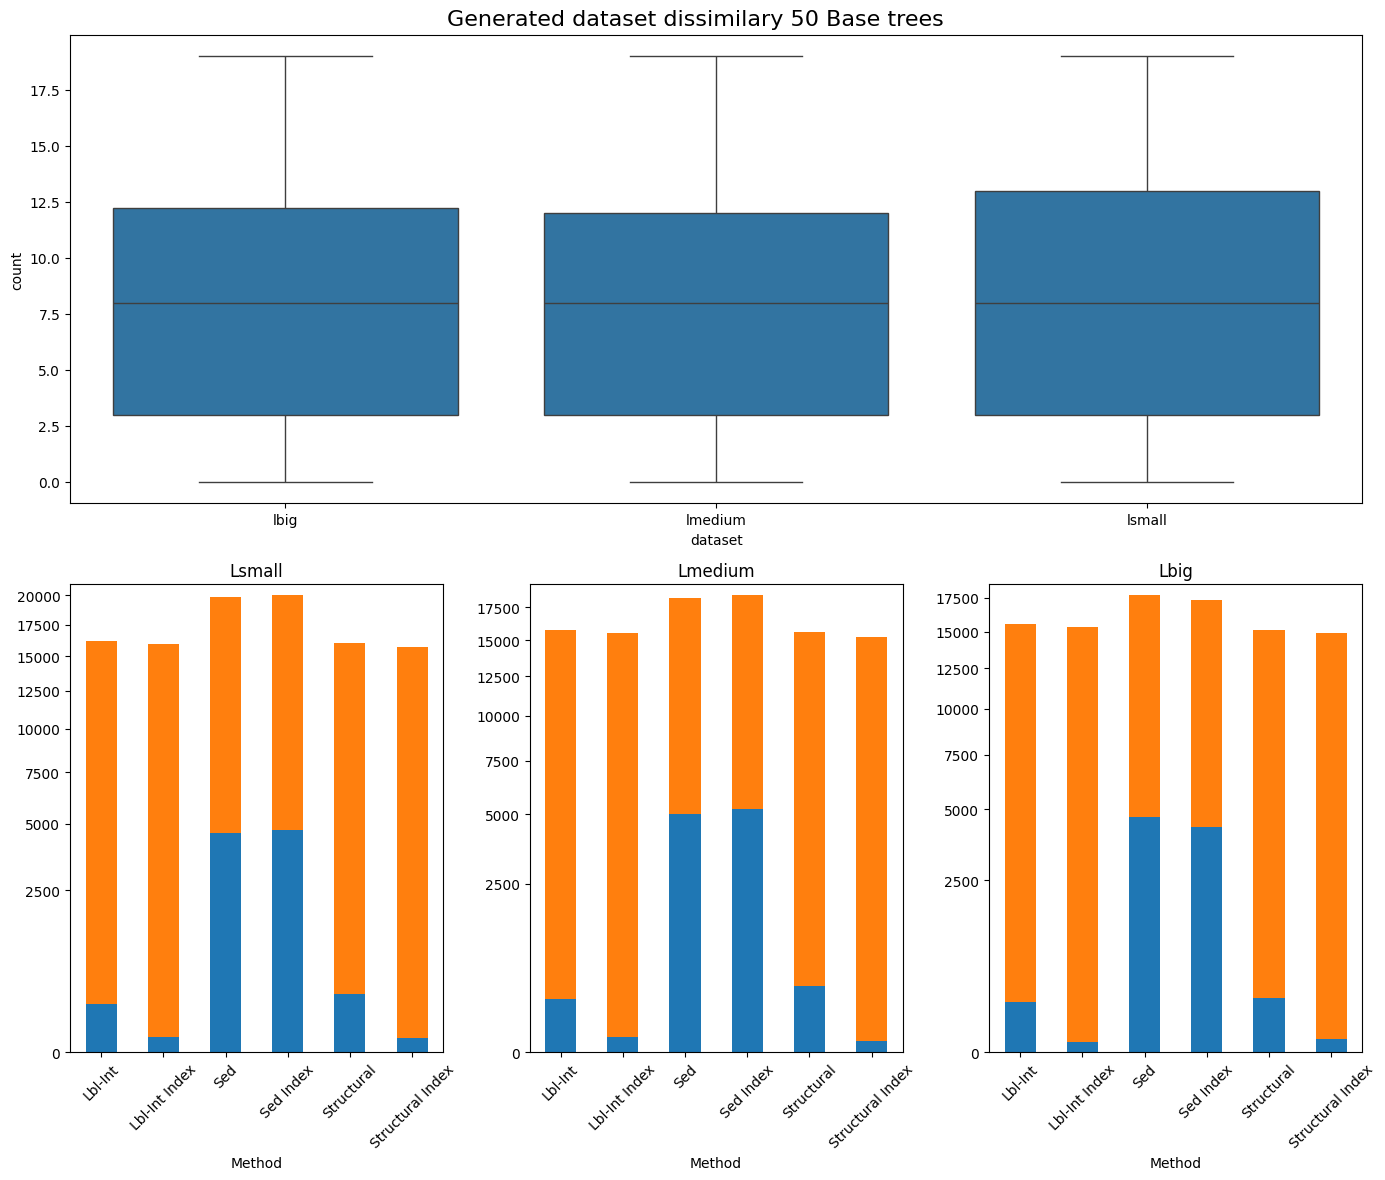

In [35]:
print_generated_dissimilar('resources/workloads/generated/base-50', '50 Base trees')

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels
0,Lsmall,89,117,103.568,1000,0.082,46.948,2986
0,Lmedium,89,116,103.905,1000,4.316,47.524,9676
0,Lbig,89,119,103.140,1000,8.861,48.372,13477


,count,dataset
T1,,
0,9,lbig
1,8,lbig
2,7,lbig
3,8,lbig
4,5,lbig
...,...,...
995,0,lsmall
996,0,lsmall
997,0,lsmall


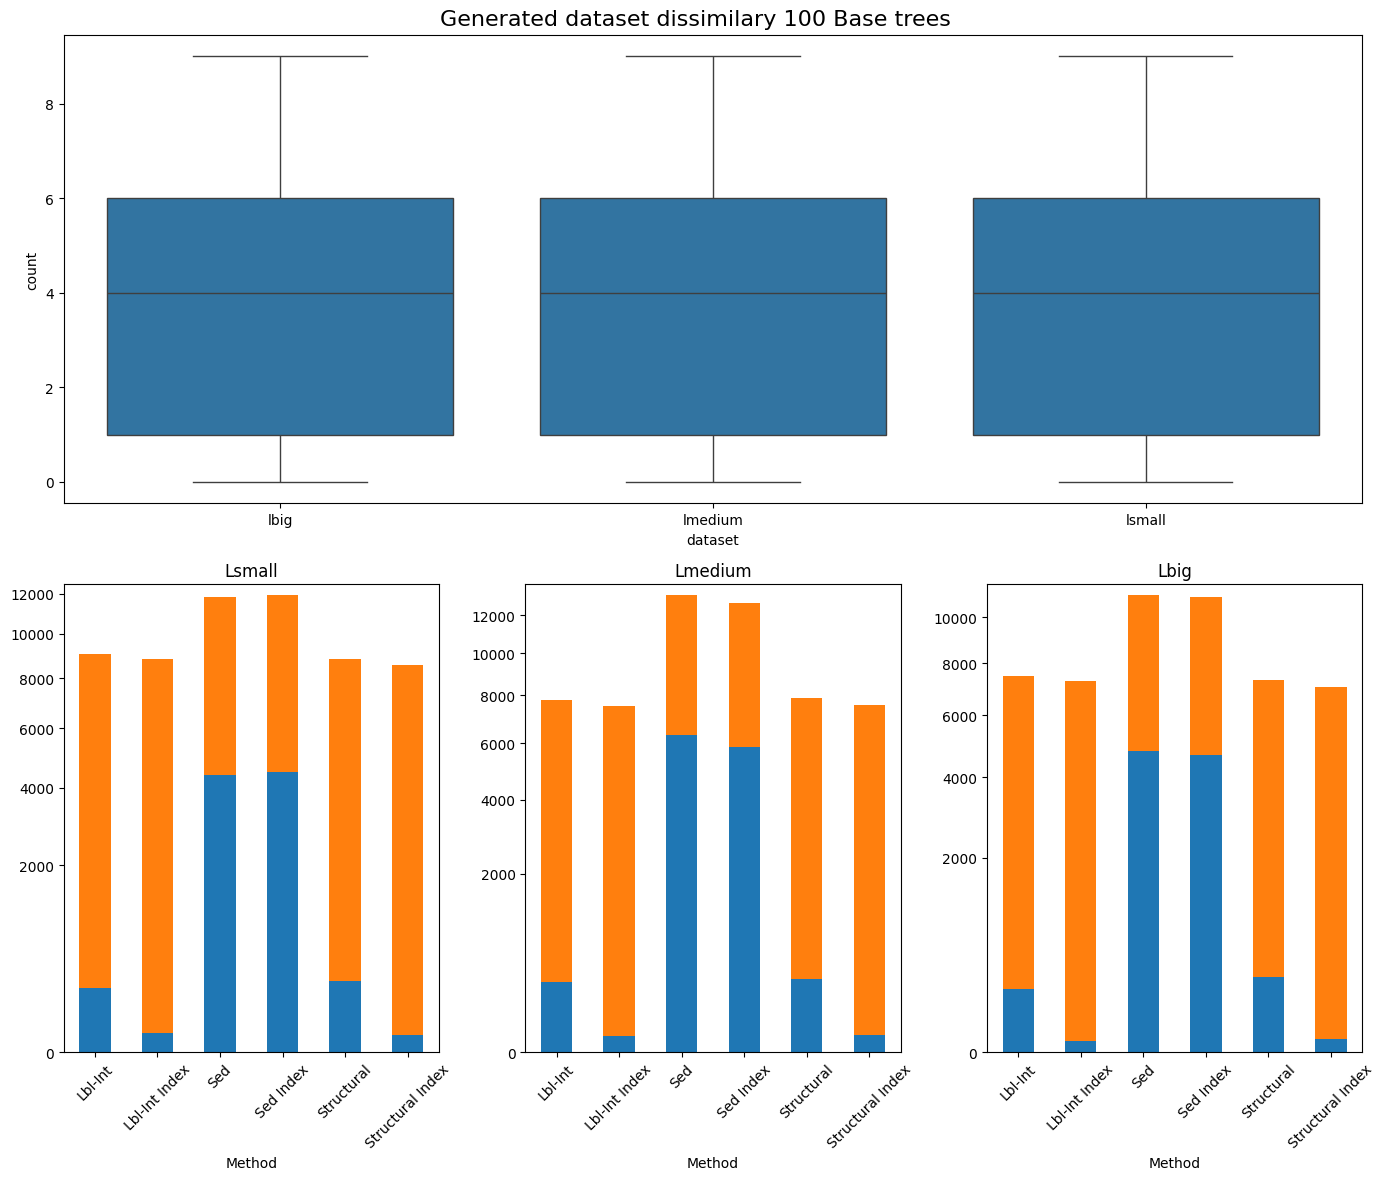

In [36]:
print_generated_dissimilar('resources/workloads/generated/base-100', '100 Base trees')

,Dataset,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,No. of distinct labels
0,Lsmall,91,117,102.583,1000,0.029,45.958,2995
0,Lmedium,90,118,103.156,1000,3.342,46.031,10484
0,Lbig,89,118,103.035,1000,7.534,46.636,15077


,count,dataset
T1,,
0,2,lbig
1,4,lbig
2,3,lbig
3,4,lbig
4,4,lbig
...,...,...
995,0,lsmall
996,1,lsmall
997,0,lsmall


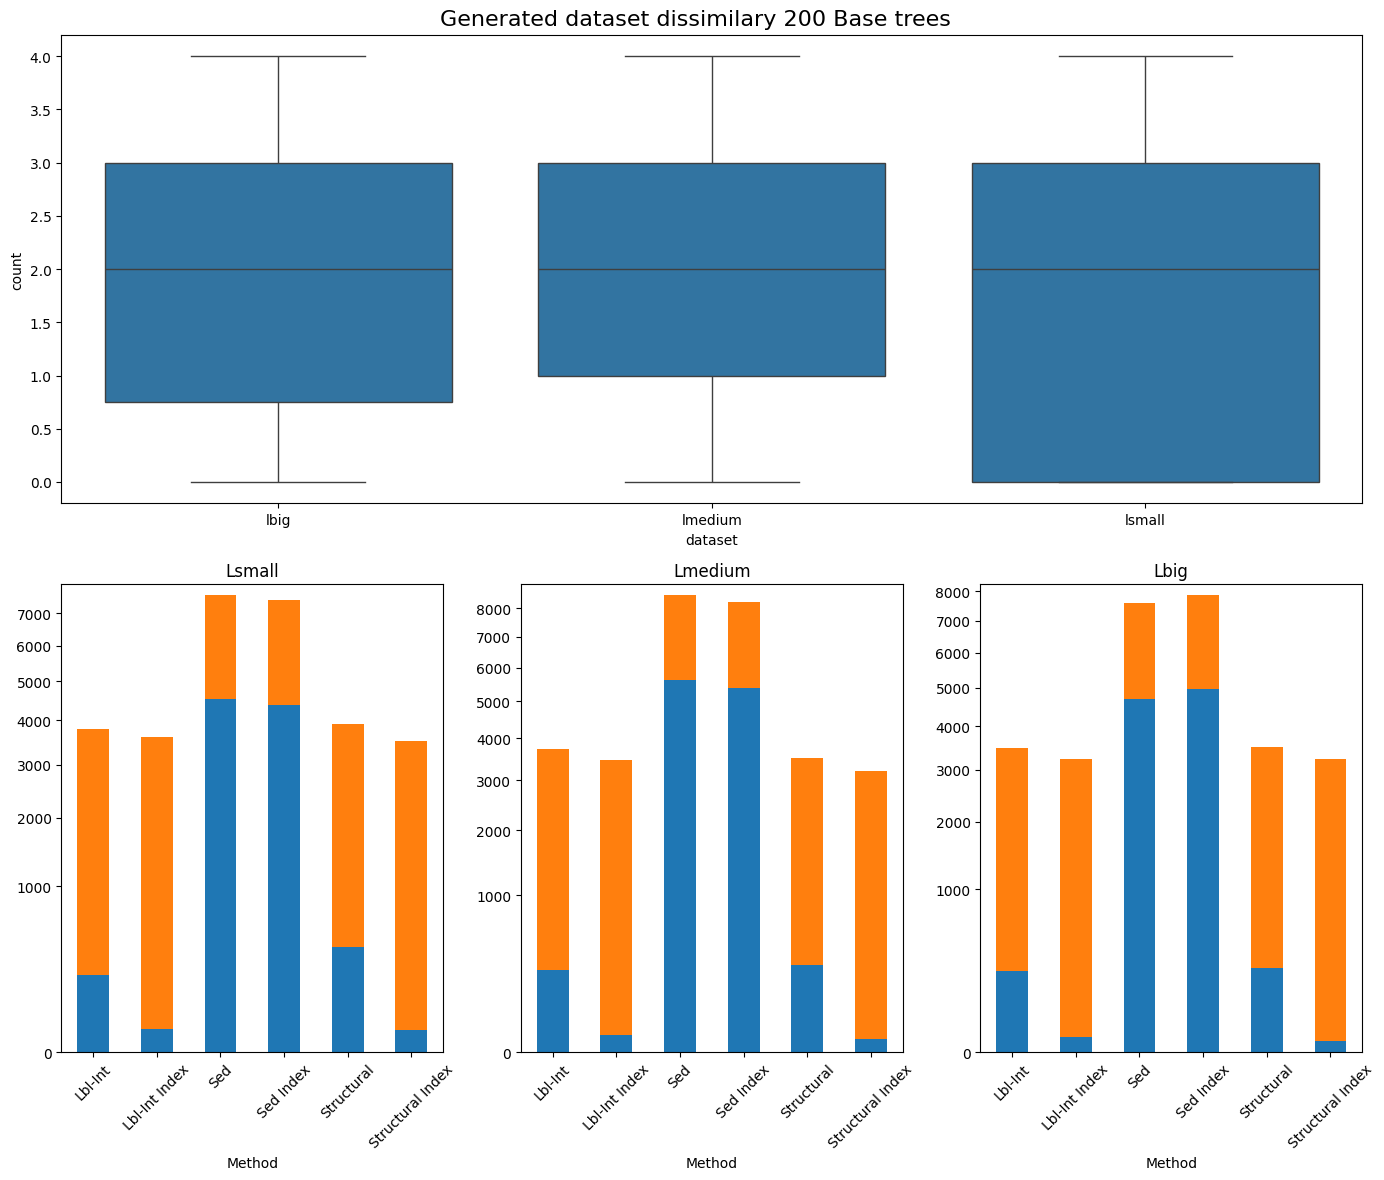

In [42]:
print_generated_dissimilar('resources/workloads/generated/base-200', '200 Base trees')

In [38]:
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

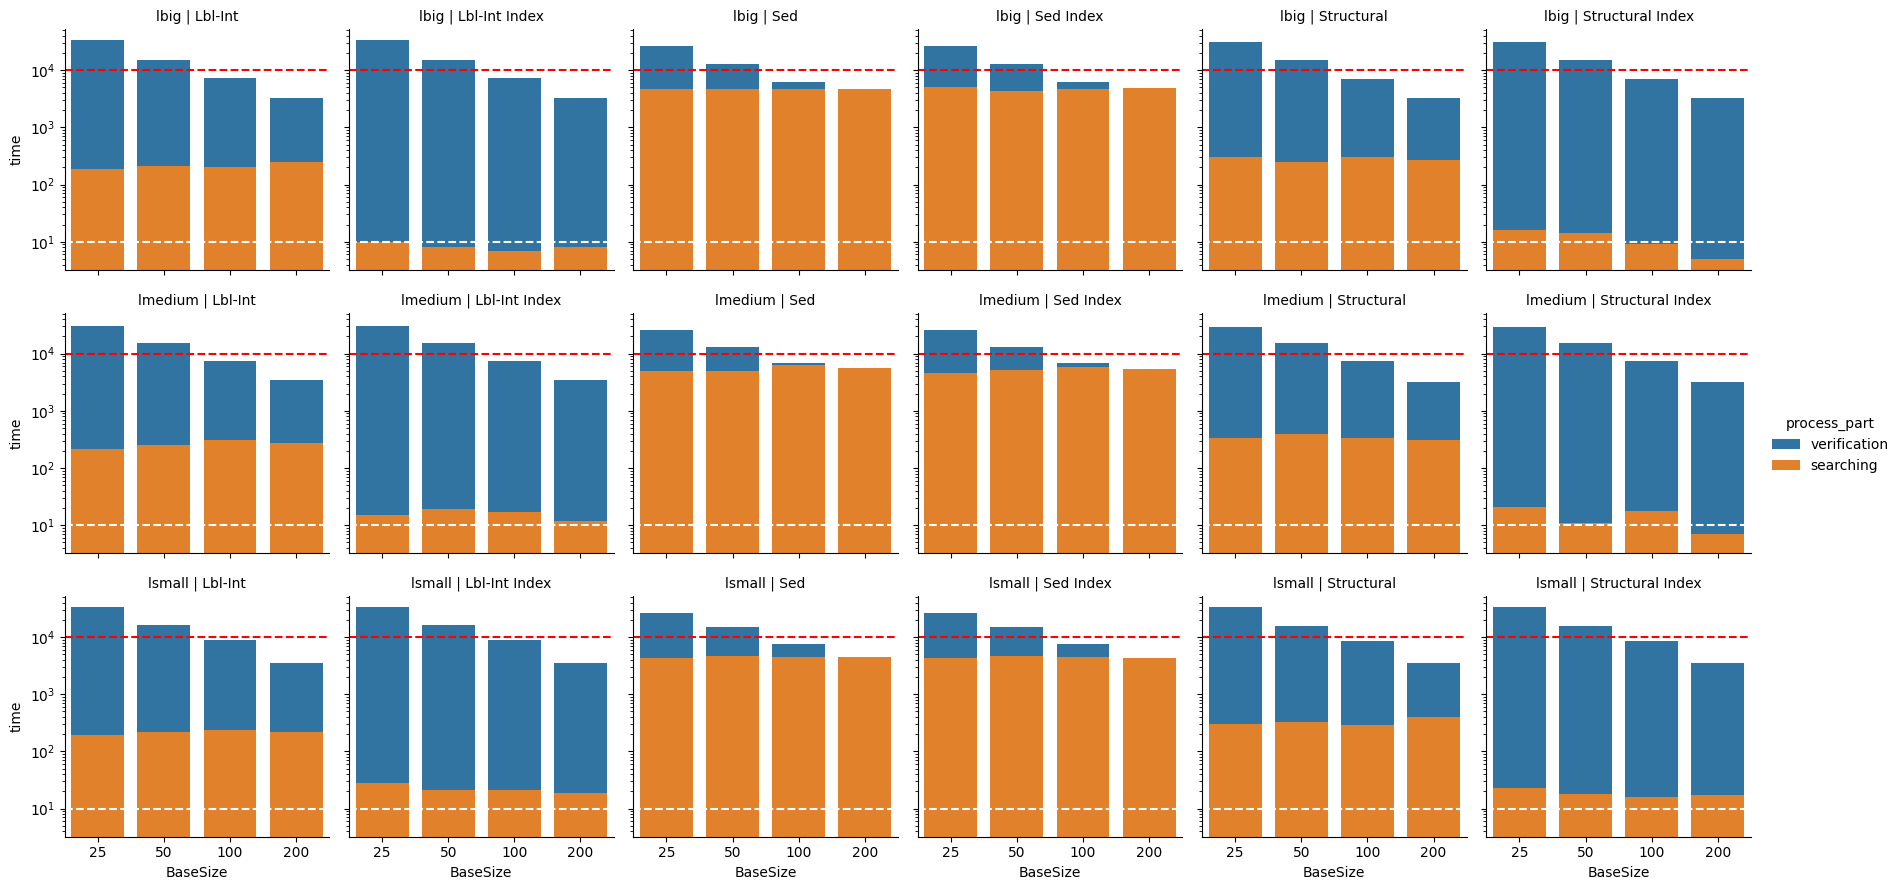

In [68]:
# ax = plt.figure(figsize=(14, 18))
# tips=sns.load_dataset("tips")
# sns.set(font_scale=2.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'Method',
    row = 'LabelSize',
    hue = 'process_part',
    # ax=ax,
    # height=5,
    # aspect=1.5,
    # gridspec_kws={"wspace":1.1, "hspace":0.4}
    )
g = (g.map(sns.barplot, 'BaseSize', 'time', errorbar = None, order=['25', '50', '100', '200']).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Annotate bars
# for ax in axes:
#     for p in ax.patches[0:4]:
#         ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.1f}'.format(p.get_height()), 
#                 ha='center', va='center', fontsize=10, color='white', rotation=0)

# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
g.savefig("Facet.png")

In [121]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [115]:
BASEPATH

'resources/workloads/generated'

In [103]:
qdf = get_query_runtime_for_df(BASEPATH, 'lsmall')

In [ ]:
times_df.transpose()

Dataset,lsmall
Lblint index,182
Lblint,605
Sed Index,4709
Sed,4708
Structural Index,40
Structural,993


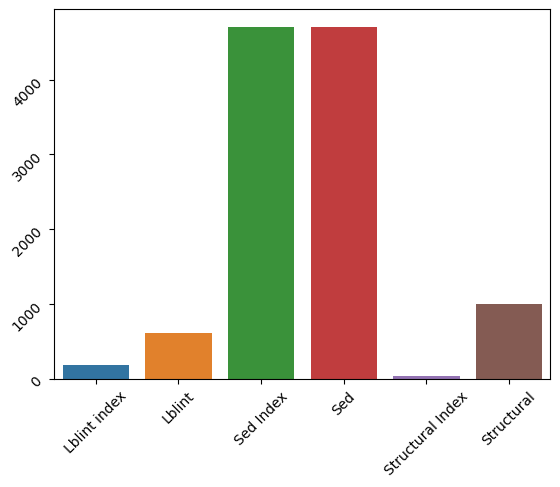

In [ ]:
bx = sns.barplot(times_df)
bx.tick_params(rotation=45)

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
query_times_df = times_df.transpose()
f.suptitle('Query time for each dataset (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(query_times_df[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(query_times_df[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')


In [ ]:
times_df = pd.DataFrame()
candidates_df = pd.DataFrame()
for ds in datasets:
    times_path = join('resources/puser-results', ds, 'times.txt')
    t = pd.read_csv(times_path, delimiter=';')
    t = t.rename(columns=ALGORITHMS)
    times_df = pd.concat([times_df, t.head(1)])
    
    candidates_df = pd.concat([candidates_df, t.iloc[[1]]])
times_df = times_df.set_index('dataset')
candidates_df = candidates_df.set_index('dataset')
# display(df)
display(times_df.transpose())
display(candidates_df)

,count
T1,
0,3
1,3
2,3
3,0
4,3
...,...
294,0
295,0
296,0


# Divided datasets processing

Each dataset is divided into 3 groups by tree sizes (small, medium and large). Then from each group a query set is taken, run againts the original
DS

In [5]:
# For now, only some datasets have finished measurements
lower_bounds = ('Lblint', 'Sed', 'Structural')
# datasets = ['bolzano', 'sentiment', 'ptb', 'dblp']
datasets = ['sentiment', 'python', 'rna', 'dblp', 'ptb', 'treefam']

### Utility functions

In [6]:
from matplotlib import gridspec
from os.path import exists, join
from io import StringIO  
from datetime import timedelta
import math
hue_color_palette = {'searching': sns.color_palette()[0], 'verification': sns.color_palette()[1]}

In [7]:
# Get the searching query runtime for a dataset
def get_query_runtime_for_ds(basepath: str, ds: str):
    qt = join(basepath, ds, f'query_times.csv')
    with open(qt) as f:
        content = f.read().split('\n')

    times = [int(l.split(':')[1].strip('ms')) for i, l in enumerate(content) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content) if i % 3 == 2]
    methods = [l for i, l in enumerate(content) if i % 3 == 0 and l]
  
    csv_content = ','.join(methods) + '\n' +','.join(map(str, times))  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [8]:
# Returns 3 dataframes, search time DF, candidates DF, and query stats DF
def get_searching_part(basepath: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    times_df = pd.DataFrame()
    candidates_df = pd.DataFrame()
    stats_df = pd.DataFrame()
    for ds in datasets:
        query_times_df = get_query_runtime_for_ds(basepath, ds)
        times_df = pd.concat([times_df, query_times_df.iloc[[0]]])
        candidates_df = pd.concat([candidates_df, query_times_df.iloc[[1]]])
        stats = pd.read_csv(join(basepath, ds, 'queries-stats', 'collection.csv'))

        try:
            queries = pd.read_csv(join(basepath, ds, 'queries.csv'), delimiter=';', header=None, names=['threshold', 'tree'])
        except:
            with open(join(basepath, ds, 'queries.csv')) as f:
                queryTaus = [int(l.split(';', 1)[0]) for l in f]
            queries = pd.DataFrame(queryTaus, columns=['threshold'])
        
        stats.insert(0, 'Dataset', [ds.capitalize()])
        stats.insert(1, 'Avg. query Tau', [queries['threshold'].mean()])
        stats.insert(2, 'NumQueries', [len(queries)])
        stats_df = pd.concat([stats_df, stats])

    times_df = times_df.rename(columns={
        'Lblint index': ALGORITHMS['lblindex'],
        'Lblint': ALGORITHMS['lblint'],
        'Sed Index': ALGORITHMS['sedindex'],
        'Sed': ALGORITHMS['sed'],
        'Structural Index': ALGORITHMS['structuralindex'],
        'Structural': ALGORITHMS['structural'],
        })
    times_df = times_df.set_index('Dataset')
    candidates_df = candidates_df.set_index('Dataset')
    times_df['process_part'] = 'searching'

    return times_df, candidates_df, stats_df

In [9]:
# returns precision, verification times and selectivies
def get_precision_and_verification_for_ds(basepath: str, cdf: pd.DataFrame, trees_in_ds: dict) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # precision dataframe
    pdf = pd.DataFrame()
    # verification times dataframe
    vdf = pd.DataFrame()
    selectivites = pd.DataFrame()
    for ds in datasets:
        total_trees_in_ds = trees_in_ds[ds]
        temp_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
        times_ = []
        methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
        df_all = pd.read_csv(join(basepath, ds, 'verified-all.txt'))
        for mtd in ('Lblint', 'Sed', 'Structural'):
            candidates_df = pd.read_csv(join(basepath, ds, f'{mtd}_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
            method_verified_candidates_df = df_all.merge(candidates_df, on=['query_id', 'candidate_id'], how='inner')
            candidate_count = cdf.loc[ds.lower(), mtd]
            times = method_verified_candidates_df['verification_time_micro']
            correct_results = method_verified_candidates_df[method_verified_candidates_df['passed'] == 1]
            precision =  (len(correct_results) / candidate_count)
            temp_df[mtd] = precision
            temp_df
            # convert from microseconds to milliseconds
            total_verification_time_ms = times.sum() / 1_000
            # twice for index version
            times_.extend([total_verification_time_ms, total_verification_time_ms])
            
        g = correct_results.groupby('query_id').count()
        # it must be divided by the count of all trees in dataset
        g['SelectivityPerQuery'] = (g['candidate_id'] / total_trees_in_ds) * 100
        g['Dataset'] = ds.capitalize()
        selectivites = pd.concat([selectivites, g])
        pdf = pd.concat([pdf, temp_df])
        # times 6 because we have 3 methods and 2 versions - indexed and not indexed
        vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
        
    selectivites.set_index("Dataset")
    pdf = pdf.set_index("Dataset")
    vdf.sort_values(['Dataset', 'Method',], inplace=True)
    return pdf, vdf, selectivites


In [10]:
from dataclasses import dataclass

@dataclass
class PlotData:
    # precision DF
    pdf: pd.DataFrame
    # verification times DF
    vdf: pd.DataFrame
    # selectivity DF
    sdf: pd.DataFrame
    # data frames for plotting
    plotdata: pd.DataFrame
    # statistics
    statistics: pd.DataFrame

In [11]:
def get_plot_data_ds(basepath: str, tree_count_in_ds: dict) -> PlotData:
    df, cdf, statistics = get_searching_part(basepath)
    pdf, vdf, sdf = get_precision_and_verification_for_ds(basepath, cdf, tree_count_in_ds)
    
    df['Dataset'] = df.index.get_level_values('Dataset')
    ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])
    complete = pd.concat([ldf, vdf])
    plot_data = complete.pivot_table(
        index=['Dataset', 'Method'],
        columns='process_part',
        values='Time'
    ).reset_index()
    plot_data['total'] = plot_data['searching'] + plot_data['verification']

    return PlotData(
        pdf = pdf,
        vdf = vdf,
        sdf = sdf,
        plotdata = plot_data,
        statistics = statistics,
        # dissimilarity = get_dissimilarity(basepath)
    )

In [12]:
def plot_broken_stacked_bars(data, order, break_bottom=15, break_top=450, height_ratios=[2, 1], *args, **kwargs):
    # display(data)
    """Create a broken axis stacked bar plot"""
    # Create figure and gridspec
    ax = kwargs.get('ax', plt.gca())
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax.get_subplotspec(), height_ratios=height_ratios, hspace=0.10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create two axes
    ax1 = plt.Subplot(ax.figure, gs[0])
    ax2 = plt.Subplot(ax.figure, gs[1])
    ax.figure.add_subplot(ax1)
    ax.figure.add_subplot(ax2)

    # ax.set_xticks(data["Method"])
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='Method', y='searching', 
                   color=hue_color_palette['searching'], ax=ax, order=order)
        
        # Top stack
        sns.barplot(data=data, x='Method', y='verification',
                   bottom=data['searching'],
                   color=hue_color_palette['verification'], ax=ax, order=order)
        # ax.set_xticks([])
        ax.set_xlabel("") #Remove x label
        ax.set_ylabel("") #Remove y label

    for i, total in enumerate(data['total']):
        if total > break_top:
            ax1.text(i, total, f'{total:.1f}', ha='center', va='bottom')

    for i, search_time in enumerate(data['searching']):
        subax = ax2 if search_time < break_bottom else ax1
        # if search_time < break_bottom:
        subax.text(i, search_time, f'{search_time:.1f}', ha='center', va='bottom')
                        
    # Set the limits
    ax1.set_ylim(break_top, data['total'].max() * 1.2)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .005
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    ax.tick_params(axis="x", rotation=45)
    return ax2

## Statistics of each group

In [42]:
def load_collection_stats(dataset: str, lb_method: str) -> pd.DataFrame:
    ds_path = join('./resources/workloads', 'divided', dataset.lower())
    path = join(ds_path, f'{lb_method.capitalize()}-stats', 'collection.csv')
    df = pd.read_csv(path)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(1, 'Type', [lb_method.capitalize() + ' candidates'], True)
    df.insert(8, 'Tree/Label ratio', df['tree_count'] / df['distinct_labels'])
    df.insert(8, 'Tree size/Label ratio', (df['avg_tree'] / df['distinct_labels']) * 100)
    return df

def load_queries_stats(dataset: str) -> pd.DataFrame:
    ds_path = join('./resources/workloads', 'divided', dataset.lower(), 'queries-stats')
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(1, 'Type', ['Queries'], True)
    df.insert(8, 'Tree/Label ratio', df['tree_count'] / df['distinct_labels'])
    df.insert(8, 'Tree size/Label ratio', (df['avg_tree'] / df['distinct_labels']) * 100)
    return df


stats_df = pd.DataFrame()
for i, ds, in enumerate(datasets):
    for lb in lower_bounds:
        try:
            stats = load_collection_stats(ds, lb)
        except Exception as e:
            print('Failed to load statistics for', ds, str(e))
            continue
        stats_df = pd.concat([stats_df, stats])
    stats = load_queries_stats(ds)
    stats_df = pd.concat([stats_df, stats])

pd.set_option('display.precision', 3)

stats_df.reset_index()
stats_df = stats_df.rename(columns={
    'min_tree': 'Min tree size',
    'max_tree': 'Max tree size',
    'avg_tree': 'Average tree size',
    'tree_count': 'Trees',
    'avg_unique_labels_per_tree': 'Avg. unique labels for a tree',
    'avg_tree_distinct_labels': 'Avg. distinct labels in tree',
    'distinct_labels': 'No. of distinct labels',
})


In [43]:
display(stats_df)

,Dataset,Type,Min tree size,Max tree size,Average tree size,Trees,Avg. unique labels for a tree,Avg. distinct labels in tree,Tree size/Label ratio,Tree/Label ratio,No. of distinct labels
0,Sentiment,Lblint candidates,10,60,32.550,7332,1.158,18.424,0.207,0.466,15720
0,Sentiment,Sed candidates,10,50,28.485,5227,1.302,16.593,0.237,0.435,12013
0,Sentiment,Structural candidates,10,56,31.848,7001,1.173,18.118,0.211,0.463,15128
0,Sentiment,Queries,37,39,37.950,100,7.410,21.070,4.054,0.107,936
0,Python,Lblint candidates,50,50,50.000,2535,1.444,33.966,1.286,0.652,3889
0,Python,Sed candidates,50,50,50.000,2535,1.444,33.966,1.286,0.652,3889
0,Python,Structural candidates,50,50,50.000,2535,1.444,33.966,1.286,0.652,3889
0,Python,Queries,50,50,50.000,100,1.820,33.980,21.097,0.422,237
0,Rna,Lblint candidates,8,18,13.437,1125,0.012,9.948,33.593,28.125,40
0,Rna,Sed candidates,8,17,13.359,1012,0.000,9.934,49.477,37.481,27


In [44]:
def load_hist_stats(datasets, stats_type: str, stats_kind: str):
    distinct_labels_stats = pd.DataFrame()
    for ds in datasets:
        try:
            ds_path = join('./resources/workloads/divided', ds.lower(), stats_kind)
            path = join(ds_path, stats_type + '.csv')
            df = pd.read_csv(path, header=None, names=[stats_type])
            df.insert(0, 'Dataset', [ds.capitalize()] * len(df.index), True)
            df.insert(1, 'Kind', [stats_kind.capitalize()] * len(df.index), True)
            distinct_labels_stats = pd.concat([distinct_labels_stats, df])
        except Exception as e:
            print(f"Failed to load {stats_type} stats for {ds}: {e}")
    return distinct_labels_stats

tree_sizes_stats = pd.DataFrame()
for lb in lower_bounds:
    tree_sizes_stats = pd.concat([tree_sizes_stats, load_hist_stats(datasets, 'tree_sizes', f'{lb}-stats')])

tree_sizes_stats = pd.concat([tree_sizes_stats, load_hist_stats(datasets, 'tree_sizes', f'queries-stats')])

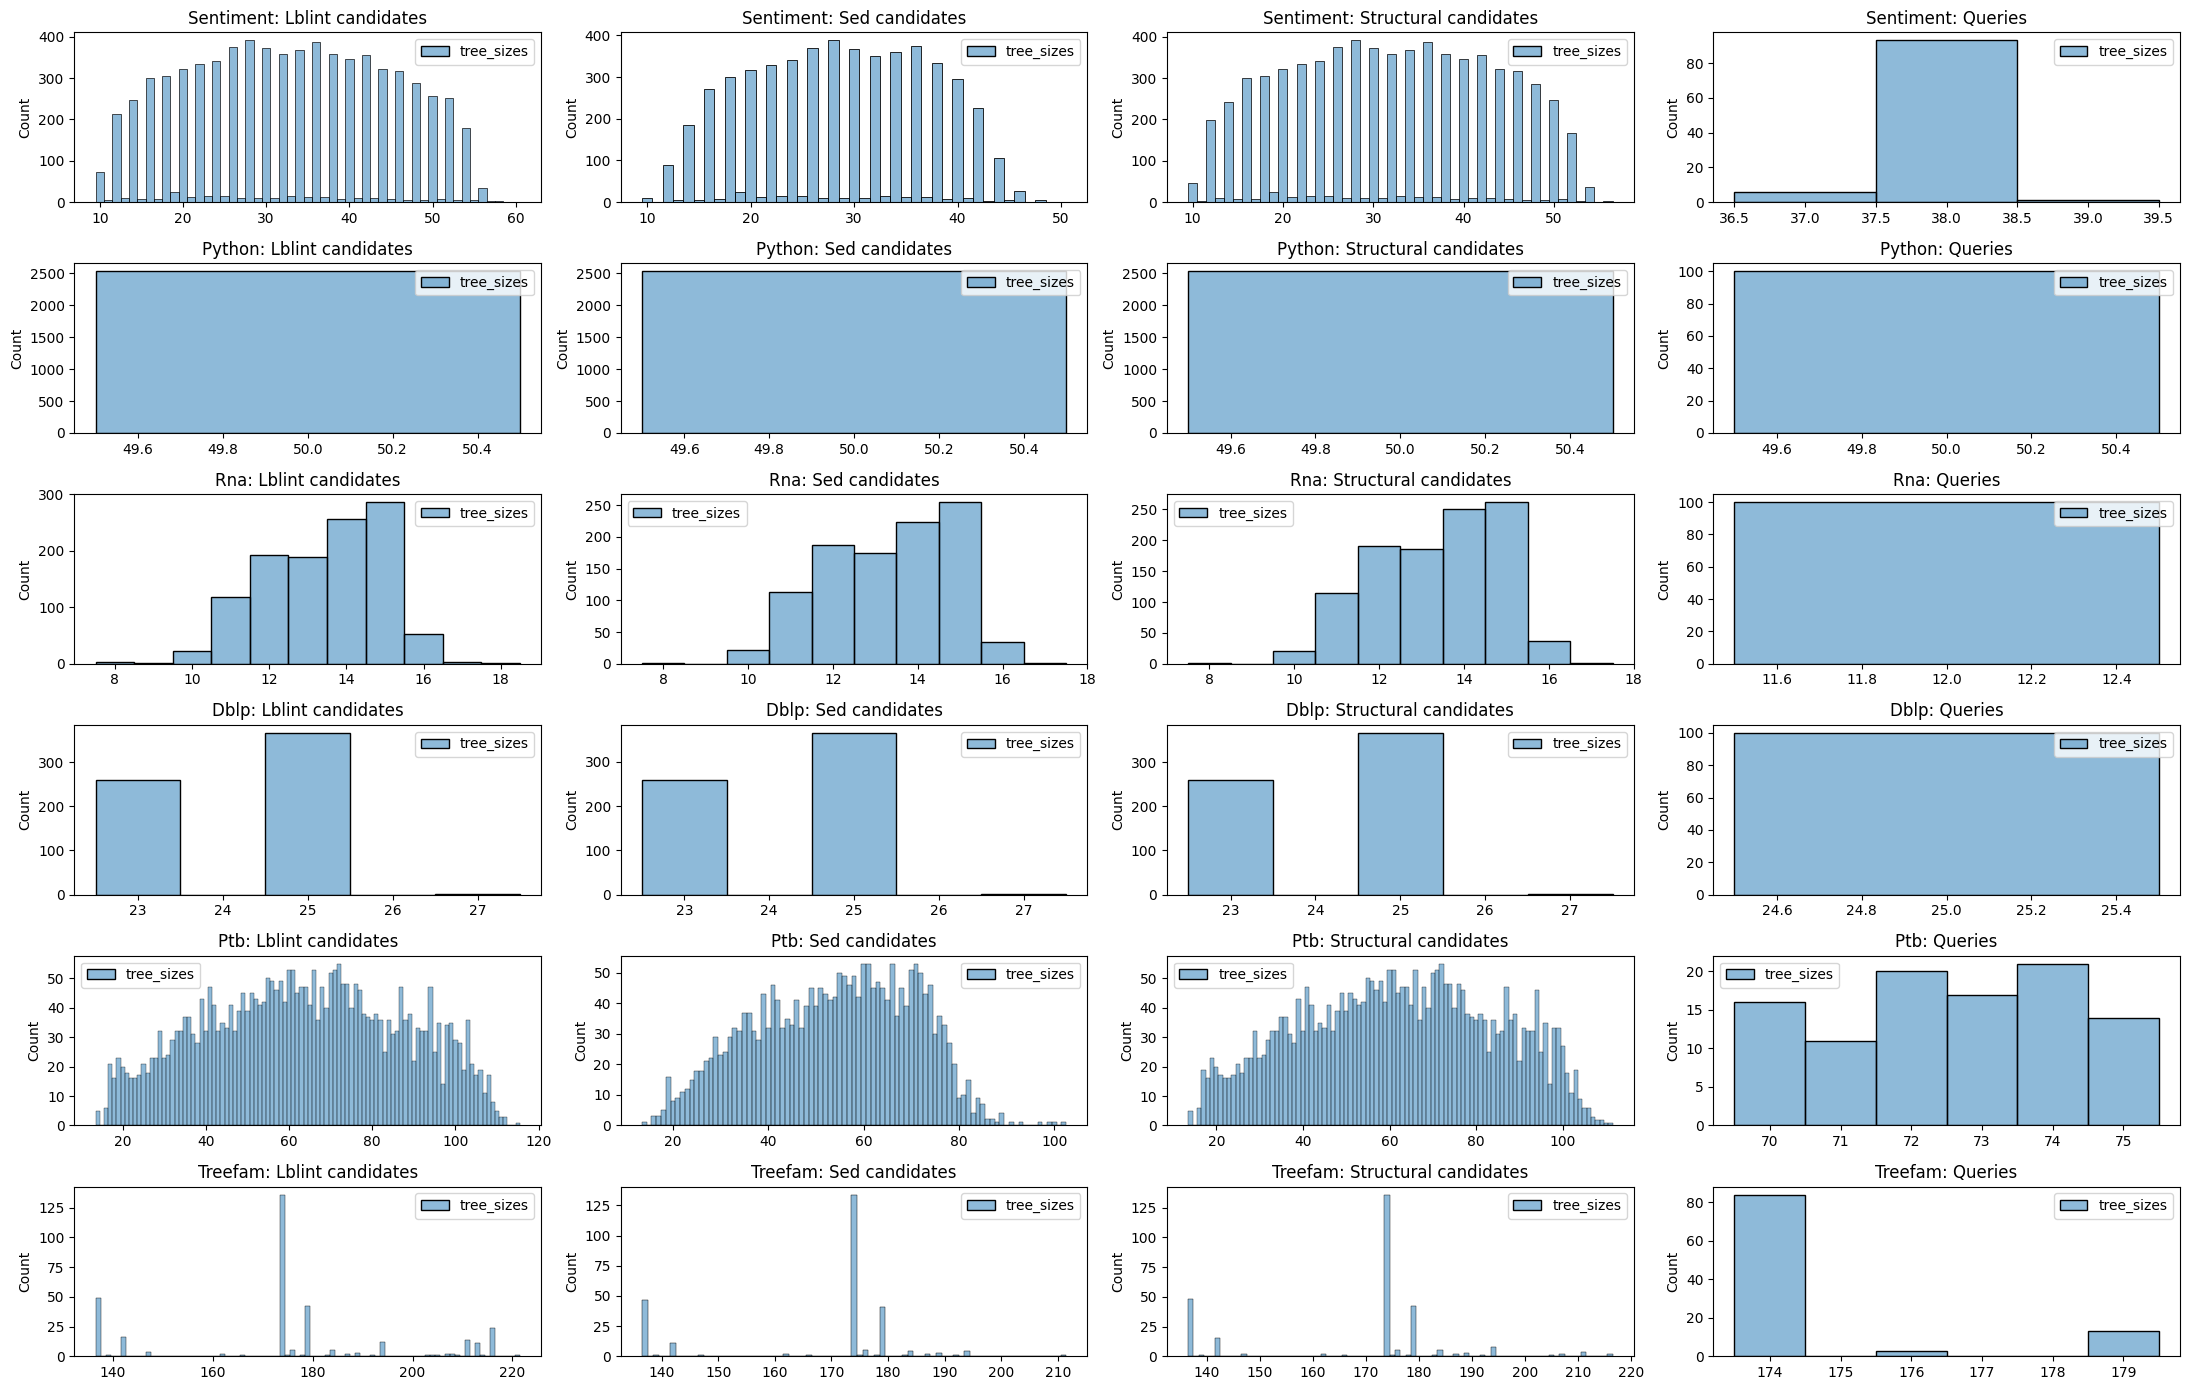

In [45]:
fig, axes = plt.subplots(6, 4, figsize=(22, 14))

kinds = lower_bounds + ('queries', )
combs = [(ds, k) for ds in datasets for k in kinds]

for (ds, kind), ax in zip(combs, axes.ravel()):
    sns.histplot(
        data = tree_sizes_stats[(tree_sizes_stats['Dataset'] == ds.capitalize()) & (tree_sizes_stats['Kind'] == kind.capitalize() + '-stats')],
        discrete=True,
        ax=ax,
    )
    title = f'{ds.capitalize()}: {kind.capitalize()}'
    title += ' candidates' if kind in lower_bounds else ''
    ax.set_title(title)
    
plt.tight_layout()

## Query results

For each group and dataset get the resulting search + verification time

In [37]:
ds_tree_count = dict()
for ds in datasets:
    
    ds_path = join('resources/workloads/traditional', ds.lower() + '_sorted.bracket')
    with open(ds_path) as f:
        lines = [l for l in f if l.strip()]
        ds_tree_count[ds] = len(lines)
ds_tree_count

{'sentiment': 9645,
 'python': 50000,
 'rna': 16819,
 'dblp': 150000,
 'ptb': 3832,
 'treefam': 5000}

In [38]:
BASEPATH = 'resources/workloads/divided'
df, cdf, statistics = get_searching_part(BASEPATH)
pdf, vdf, sdf = get_precision_and_verification_for_ds(BASEPATH, cdf, ds_tree_count)

In [39]:
data = get_plot_data_ds(BASEPATH, ds_tree_count)

<Axes: ylabel='Dataset'>

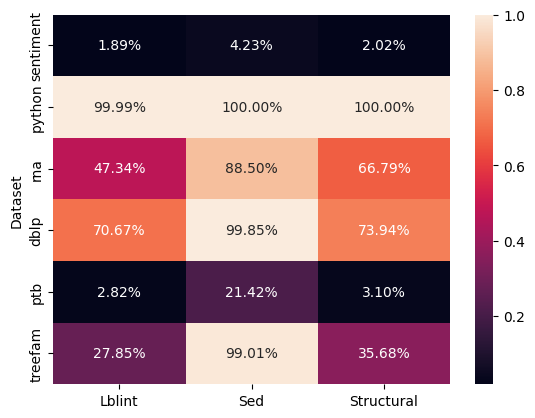

In [41]:
sns.heatmap(data.pdf, annot=True, fmt='.2%')

,Dataset,SelectivityPerQuery
0,Dblp,0.897
1,Ptb,1.785
2,Python,2.806
3,Rna,1.456
4,Sentiment,0.943
5,Treefam,1.236


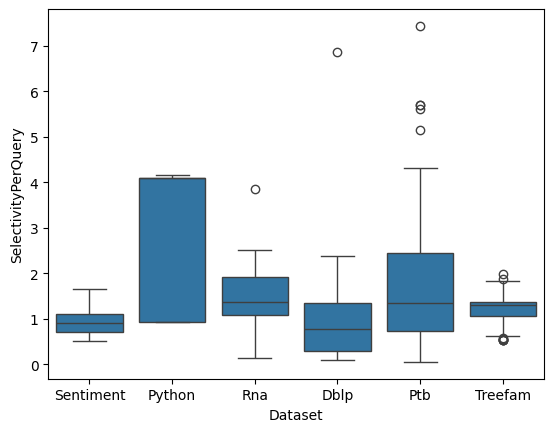

In [46]:
sns.boxplot(data=data.sdf, x="Dataset", y="SelectivityPerQuery")
data.sdf.groupby('Dataset')['SelectivityPerQuery'].mean().reset_index()

In [47]:
datasets

['sentiment', 'python', 'rna', 'dblp', 'ptb', 'treefam']

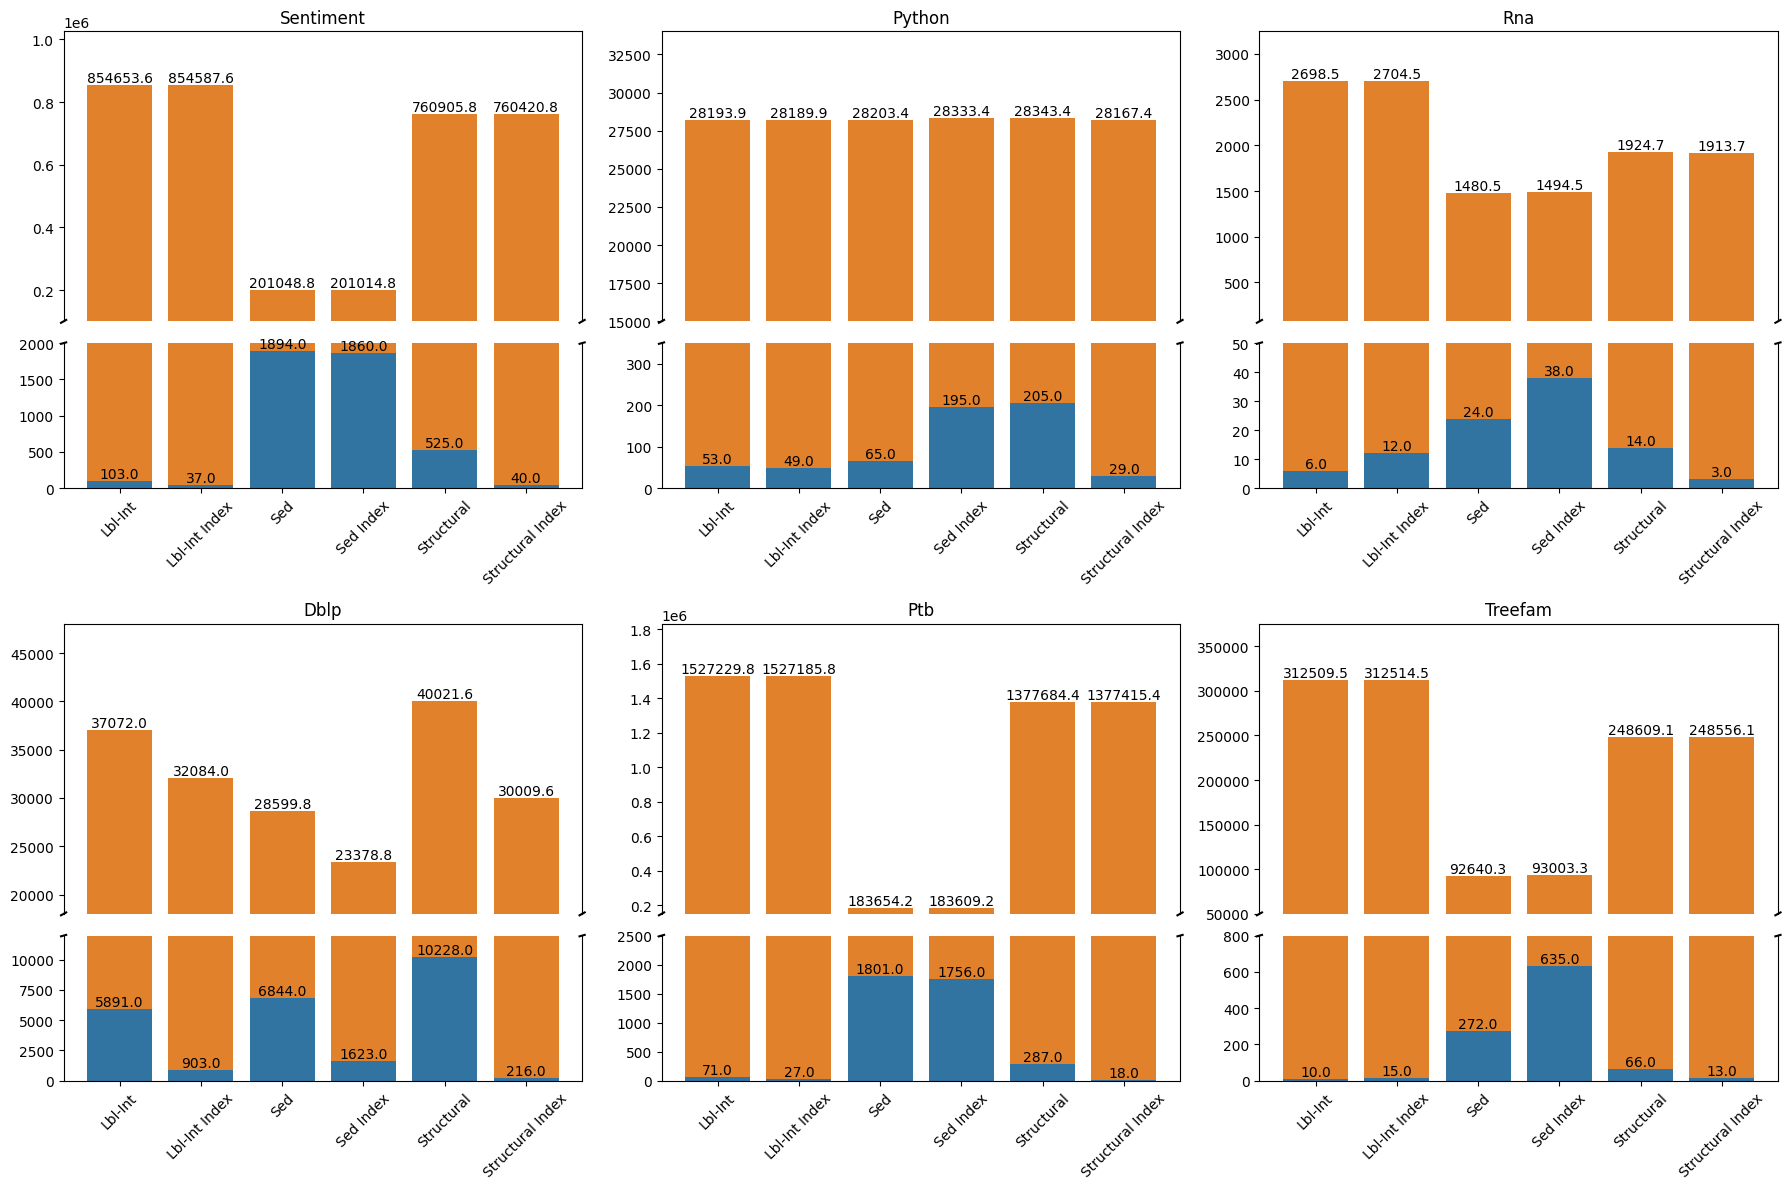

In [49]:
breaks = dict(
    # bolzano=dict(small=20, medium=100, large=20),
    sentiment=(2000, 100_000),
    python=(350, 15_000),
    dblp=12000,
    ptb=(2_500, 150_000),
    treefam=(800, 50_000),
    rna=50,
)
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = np.array([axes]) if not isinstance(axes, np.ndarray) else axes
for ds, ax in zip(datasets, axes.ravel()):
    break_top = 0
    break_bottom = 0
    if isinstance(breaks[ds], tuple):
        break_bottom, break_top = breaks[ds]
    else:
        break_bottom = breaks[ds]
        break_top = breaks[ds] + (breaks[ds] // 2)
    
    bp = plot_broken_stacked_bars(
        data.plotdata[(data.plotdata['Dataset'] == ds)],
        order,
        ax=ax,
        break_bottom = break_bottom,
        break_top = break_top
    )
    ax.set_title(f'{ds.capitalize()}')
plt.tight_layout()

# AdHoc analysis 

In [86]:
basepath = 'resources/workloads/divided/sentiment'

sed_candidates_df = pd.read_csv(join(basepath, 'Sed_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
lblint_candidates_df = pd.read_csv(join(basepath, 'Lblint_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
struct_candidates_df = pd.read_csv(join(basepath, 'Structural_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
# display(sed_candidates_df.groupby('query_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10))
verified_all_df = pd.read_csv(join(basepath, 'verified-all.txt'))
sed_verified_candidates_df = verified_all_df.merge(sed_candidates_df, on=['query_id', 'candidate_id'], how='inner')
lblint_verified_candidates_df = verified_all_df.merge(sed_candidates_df, on=['query_id', 'candidate_id'], how='inner')
struct_verified_candidates_df = verified_all_df.merge(sed_candidates_df, on=['query_id', 'candidate_id'], how='inner')
sed_passed_df = sed_verified_candidates_df[sed_verified_candidates_df['passed'] == 1]
lblint_passed_df = lblint_verified_candidates_df[lblint_verified_candidates_df['passed'] == 1]
struct_passed_df = struct_verified_candidates_df[struct_verified_candidates_df['passed'] == 1]
# display(passed_df.groupby('query_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10))
display(sed_passed_df[sed_passed_df['passed'] == 1].groupby('query_id').count().sort_values(by='candidate_id', ascending=False).head())
display(lblint_passed_df[lblint_passed_df['passed'] == 1].groupby('query_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head())
display(struct_passed_df[struct_passed_df['passed'] == 1].groupby('query_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head())


,candidate_id,verification_time_micro,final_ted,passed
query_id,,,,
45,103,103,103,103
25,101,101,101,101
51,94,94,94,94
38,93,93,93,93
43,92,92,92,92


,query_id,counts
45,45,103
25,25,101
51,51,94
38,38,93
43,43,92


,query_id,counts
45,45,103
25,25,101
51,51,94
38,38,93
43,43,92


In [88]:
BASEPATH

'resources/workloads/divided'

In [104]:
mtd = 'Sed'
ds = 'sentiment'
candidates_df = pd.read_csv(join(BASEPATH, ds, f'{mtd}_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
method_verified_candidates_df = verified_all_df.merge(candidates_df, on=['query_id', 'candidate_id'], how='inner')
candidate_count = cdf.loc[ds.lower(), mtd]
times = method_verified_candidates_df['verification_time_micro']
correct_results = method_verified_candidates_df[method_verified_candidates_df['passed'] == 1]
precision =  len(correct_results) / candidate_count

# get precision for each query_id
g = method_verified_candidates_df.groupby('query_id')
all_counts = g.size()
passed_counts = g['passed'].sum()
precision = passed_counts / all_counts
precision.mean()

np.float64(0.03928045845475411)

In [26]:
verified_all_df

,query_id,candidate_id,verification_time_micro,final_ted,passed
0,18,789,625,inf,0
1,16,1274,627,inf,0
2,35,1139,808,32.0,1
3,92,1426,990,inf,0
4,37,1707,1026,inf,0
...,...,...,...,...,...
645008,91,5057,1003,inf,0
645009,90,5357,1169,inf,0
645010,89,5657,1096,inf,0
645011,88,5957,1036,inf,0


In [44]:
query_taus = pd.read_csv(join(basepath, 'queries_to_original_id_map.csv'), delimiter=';')
query_taus

,qid,tid,tau
0,0,5583,32
1,1,5491,32
2,2,5484,32
3,3,5503,32
4,4,5289,32
...,...,...,...
95,95,5318,33
96,96,5424,33
97,97,5547,33
98,98,5592,33


In [28]:
mdf = verified_all_df.merge(query_taus, left_on='query_id', right_on='qid', how='inner')

In [29]:
mdf[(mdf['query_id'] == 52) & (mdf['passed'] == 1)]

,query_id,candidate_id,verification_time_micro,final_ted,passed,qid,tid,tau
248846,52,587,540,33.0,1,52,4992,33
249910,52,575,469,32.0,1,52,4992,33
250228,52,569,489,32.0,1,52,4992,33
250509,52,568,485,32.0,1,52,4992,33
250893,52,567,476,33.0,1,52,4992,33
...,...,...,...,...,...,...,...,...
571726,52,2759,1617,33.0,1,52,4992,33
573007,52,4168,1977,31.0,1,52,4992,33
573762,52,4055,2122,33.0,1,52,4992,33
577675,52,6148,3054,30.0,1,52,4992,33


In [31]:
query_tau_df = mdf[mdf['passed'] == 1].groupby(['query_id', 'tau']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
query_tau_df

,query_id,tau,counts
52,52,33,1531
40,40,33,1373
53,53,33,1350
94,94,33,1232
81,81,33,1199
...,...,...,...
76,76,33,430
65,65,33,426
18,18,32,420
20,20,32,381


In [ ]:
qs = dict()
for index, row in query_tau_df.iterrows():
    tau_shape = row['counts']
    ct = row['tau']
    while tau_shape > 150:
        fdf = verified_all_df[
            (verified_all_df['query_id'] == row['query_id'])
            & (verified_all_df['passed'] == 1) 
            & (verified_all_df['final_ted'] <= ct)
            ]
        # print('QID: ', row['query_id'], 'Tau: ', ct,  fdf.shape[0])
        ct -= 1
        tau_shape = fdf.shape[0]
    qs[int(row['query_id'])] = (int(ct), tau_shape)


# for q, res in qs.values():
#     if res < 100:
#         print(q, res)

print(qs)

queries = list(range(100))
for qid, (tau, counts) in qs.items():
    queries[qid] = tau

for qid, tau in enumerate(queries):
    print(qid, queries[qid])

In [60]:
with open(join(basepath, 'queries copy.csv')) as f:
    orig_queries = [f.strip().split(';') for f in f]

for qid, tau in enumerate(queries):
    orig_queries[qid][0] = tau

for tau, query in orig_queries:
    print(tau, query)
    
with open(join(basepath, 'queries.csv'), 'w') as f:
    for tau, query in orig_queries:
        f.write(f'{tau};{query}' + '\n')

29 {4{3{2 A}{3{2{3 rare}{2 and}}{3{2 lightly}{4 entertaining}}}}{3{2{2 look}{2{2 behind}{2{2{2 the}{2 curtain}}{2{2 that}{3{2{2 separates}{2 comics}}{3{2 from}{3{2{2 the}{2 people}}{3{4 laughing}{2{2 in}{2{2 the}{2 crowd}}}}}}}}}}}}}
28 {3{2{2 An}{3{4 engaging}{2 criminal}}}{2{3{2 romp}{3{2 that}{2{2 will}{4{2 have}{2{2{2 viewers}{2{2 guessing}{2 just}}}{3{2 who}{1{2 's}{2{2 being}{2{2{1 conned}{2{3 right}{2 up}}}{2{2 to}{2{2 the}{2 finale}}}}}}}}}}}}}}
29 {3{2 Will}{3{3 certainly}{3{3{2{3{3 appeal}{2{2 to}{2{2 Asian}{2{1 cult}{3{2 cinema}{3 fans}}}}}}{2 and}}{2{2 Asiaphiles}{2{3 interested}{3{2 to}{2{2 see}{2{2 what}{2{2{2 all}{2{2 the}{2 fuss}}}{2{2 is}{2 about}}}}}}}}}}}}
28 {3{2{2 The}{2 movie}}{3{4{2{2 is}{2 ...}}{3{4{2 very}{3 funny}}{3{2 as}{3{2 you}{3{2{2 peek}{2{2 at}{2 it}}}{2{2 through}{2{2{2 the}{2 fingers}}{2{2 in}{2{2 front}{3{2 of}{2{2 your}{2 eyes}}}}}}}}}}}}}}
28 {1{1{1 Unambitious}{2 writing}}{2{1{2{2{2 emerges}{2{2 in}{2{2 the}{2 movie}}}}{2 ,}}{1{2 using}{2{2{2 a}{2

In [148]:
verified_all_df['original_tree_id'] = 4992
verified_52 = verified_all_df[(verified_all_df['query_id'] == 52) & (verified_all_df['passed'] == 1)]
# verified_all_df[(verified_all_df['query_id'] == 52) & (verified_all_df['passed'] == 1)].groupby(['query_id', 'candidate_id'])\
#     .size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10)

In [149]:
verified_52

,query_id,candidate_id,verification_time_micro,final_ted,passed,original_tree_id
248846,52,587,540,33.0,1,4992
249910,52,575,469,32.0,1,4992
250228,52,569,489,32.0,1,4992
250509,52,568,485,32.0,1,4992
250893,52,567,476,33.0,1,4992
...,...,...,...,...,...,...
571726,52,2759,1617,33.0,1,4992
573007,52,4168,1977,31.0,1,4992
573762,52,4055,2122,33.0,1,4992
577675,52,6148,3054,30.0,1,4992


In [120]:
distances_df = pd.read_csv('resources/workloads/traditional/distances-sentiment.csv', header=None, names=['T1', 'T2', 'Distance'])

In [152]:
distances_df[distances_df['T1'] == 4992].count()
distances_4992= distances_df[distances_df['T1'] == 4992]
distances_4992

,T1,T2,Distance
12457536,4992,0,36
12457537,4992,1000,43
12457538,4992,100,37
12457539,4992,10,36
12457540,4992,1,36
...,...,...,...
12462523,4992,995,46
12462524,4992,996,46
12462525,4992,997,45
12462526,4992,998,46


In [153]:
mdf = distances_4992.merge(verified_52, left_on='T2', right_on='candidate_id', how='inner')

In [154]:
mdf

,T1,T2,Distance,query_id,candidate_id,verification_time_micro,final_ted,passed,original_tree_id
0,4992,1001,42,52,1001,837,31.0,1,4992
1,4992,1002,42,52,1002,773,33.0,1,4992
2,4992,1003,39,52,1003,828,33.0,1,4992
3,4992,1004,46,52,1004,933,32.0,1,4992
4,4992,1006,46,52,1006,847,33.0,1,4992
...,...,...,...,...,...,...,...,...,...
1520,4992,989,42,52,989,678,30.0,1,4992
1521,4992,993,46,52,993,1057,32.0,1,4992
1522,4992,995,46,52,995,844,32.0,1,4992
1523,4992,996,46,52,996,983,31.0,1,4992


In [98]:
import polars as pl

In [99]:
df = pl.read_csv('resources/workloads/traditional/distances-sentiment.csv', has_header=False, schema={"T1": pl.Int32(), "T2": pl.Int32(), "K": pl.Int32()})

In [116]:
df.filter(( (pl.col('T1') == 4992 ) | (pl.col('T2') == 4992) ) ).select(pl.len())

len
u32
7681


In [79]:
g = df.filter((pl.col('K') <= 33)).group_by("T1").agg(pl.len().alias("cnt"))

In [80]:
g.head()

T1,cnt
i32,u32
1069,1069
3162,2061
3281,1704
146,146
3412,2099


In [82]:
display((g.filter(pl.col('T1') == 4992)).select('*'))

T1,cnt
i32,u32
4992,167


In [67]:
basepath

'resources/workloads/divided/sentiment'

In [68]:
# Read csv queries file line by line
with open(join(basepath, 'queries.csv')) as f:
    lines = [l for l in f if l.strip()]
    queries = [l.strip().split(';') for l in lines]


# increment tau for each query
for qid, (tau, query) in enumerate(queries):
    queries[qid][0] = int(tau) + 1
# Write to csv file
with open(join(basepath, 'queries.csv'), 'w') as f:
    for tau, query in queries:
        f.write(f'{tau};{query}' + '\n')